## T-cell depleted mice experiments

- 1.1 = First set of samples, first replicate
- 1.2 = first set of samples, second replicate
- 2.1 = second set of samples, first replicate
- 2.2 = Second set of samples, second replicate


Mice and IDs: 
- 1 = 21
- 2 = 22
- 3 = 23
- 4 = 24
- 5 = 25
- 6 = 26
- 7 = 27
- 8 = 28
- 9 = 29
- 30 = 10

In [1]:
suppressMessages({
message("Loading packages")
library('ggplot2')
library('readr')
library('reshape2')
library('plyr')
library('tidyverse')
library('dplyr')
library('glue')
library('seqinr')
library('stringr')
library("pals")
library('gggenes')
})

In [2]:
wkdir = '/projects/'

source(glue("{wkdir}/scripts/mehul_extra.R"))

major_cov = 10 # consensus cutoff

minor_cov = 200 # minor var cutoff

minor_freq = 0.01  # initial filter before merging replicates

stock_minor_freq = 0.005 # using a very relaxed cutoff to be confident in de novo var

sample_minor_freq = 0.02  # a more stringent cutoff for samples

genome_size = 29903  # size of reference genome

meta = read.csv(glue("{wkdir}/metadata/tcd.metadata.csv"), header = TRUE)


In [3]:
message("Load in functions and Plot prep")

message("Generate necessary directories")

FIG_DIR = glue("{wkdir}/figures/")

if (!dir.exists(FIG_DIR)) {
      dir.create(FIG_DIR)
    }

message('figures will be saved in: ', FIG_DIR)

Load in functions and Plot prep

Generate necessary directories

figures will be saved in: /Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mehul_mice/figures/



# Confirming that the passaged aliquots are all identical to the pre-passaged stock aliquots.

The consensus sequences for the seven stock samples (3 passaged and 4 pre-passaged) are compared to confirm that the consensus nucleotides are identical across all stocks. Only nucleotide sites with a read depth (rd) of at least 10x reads were compared. All stock samples had >99% coverage at 10x read depths, with only the 5' and 3' UTR and the ORF3a gene region having read depths that dropped below 10x.     

Minor variants in the stock samples were also pulled from the seven stock samples. We will use the minor variant diversity to determine 1) how passaging the virus may impact minor variant diversity and 2) define the virus variants (consensus and minor) we observe in the mouse samples as _de novo_ or as standing diversity that was potentially transferred during inoculation.   **A minor variant is defined as a nucleotide that differs from the consensus and is present at a position with at least 200x reads covering it, at 1-49% frequency, and in both sequencing replicates.**

In [4]:
stock_files = Sys.glob(glue("{wkdir}/reseq/r1/aasnplist/stock/*"), dirmark = FALSE) # pull stock information batch 1, rep 1
pull_stock_info = prep_stock(stock_files,'r1', major_cov, minor_cov, 0.005, ntlist) # rearranges information an returns 4 diff dfs
stock_con1 = pull_stock_info$stock_con
stock_var1 = pull_stock_info$stock_var


stock_files = Sys.glob(glue("{wkdir}/reseq/r2/aasnplist/stock/*"), dirmark = FALSE) # pull stock information batch 1, rep 2
pull_stock_info = prep_stock(stock_files,'r2', major_cov, minor_cov, 0.005, ntlist)
stock_con2 = pull_stock_info$stock_con
stock_var2 = pull_stock_info$stock_var

In [5]:
pass_stock_con = merge(stock_con1, stock_con2, by = c('ntpos','gene_id','aapos')) # merge the two reps for batch 1

In [6]:
temp_meta = meta %>% 
        mutate(temp1 = glue("{r1}_r1"),
               temp2 = glue("{r2}_r2"),
               temp3 = glue("{sample_name}_r3"),
               temp4 = glue("{sample_name}_r4"),
               temp1aa = glue("{r1}aa_r1"),
               temp2aa = glue("{r2}aa_r2"),
               temp3aa = glue("{sample_name}aa_r3"),
               temp4aa = glue("{sample_name}aa_r3"))

In [7]:
pass_stock_con$dp_check = pass_stock_con$B_1_351_B1dp_r1 + pass_stock_con$B_1_351_B2dp_r1 + pass_stock_con$KAF_109_31dp_r1 + pass_stock_con$B_1_351_B1dp_r2 + pass_stock_con$B_1_351_B2dp_r2 + pass_stock_con$B_1_351_B3dp_r2 # add up the pass check across samples - if they pass then it will equal the number of stock samples 3 * 2 reps = 6

stocks = unlist((temp_meta %>% filter(type == 'passaged_stock'))[c('temp1','temp2')], use.names = FALSE) # pull out the names to use for checking below

stocks_aa = unlist((temp_meta %>% filter(type == 'passaged_stock'))[c('temp1aa','temp2aa')], use.names = FALSE)

# setting up the ability to confirm that the stock samples are all identical on the consensus level
pass_stock_con = pass_stock_con %>%
    rowwise() %>% 
    mutate(is_same = n_distinct(c_across(c(all_of(stocks))))==1,
           is_same_aa = n_distinct(c_across(c(all_of(stocks_aa))))==1) %>% # determine number of different nucleotides - this will be > 1 if there is an "N" at a position in the stock
    ungroup() %>% 
    unique() 


In [8]:
# since the dp is equal to 1 or 0 if we add all - they should add up to the number of stocks that we have
message("Checking to make sure stock samples are identical - the following DF should be empty: ")

stock_numb = 6 # 3 x 2 replicates

pass_stock_con %>% filter(is_same == 'FALSE' & dp_check == stock_numb) %>% select(all_of(c(stocks, 'ntpos', 'dp_check', 'is_same'))) %>%unique()


Checking to make sure stock samples are identical - the following DF should be empty: 



KAF_109_31_r1,B_1_351_B1_r1,B_1_351_B2_r1,B_1_351_B1_r2,B_1_351_B2_r2,B_1_351_B3_r2,ntpos,dp_check,is_same
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>


In [9]:
stock_files = Sys.glob(glue("{wkdir}/additional_samples/aasnplist/r1/stock/*"), dirmark = FALSE) # looking at the pre-passaged stock virus sequences - batch 2, rep 1
pull_stock_info = prep_stock(stock_files,'r3', major_cov, minor_cov, 0.005, ntlist) 
stock_con3 = pull_stock_info$stock_con
stock_var3 = pull_stock_info$stock_var

stock_files = Sys.glob(glue("{wkdir}/additional_samples/aasnplist/r2/stock/*"), dirmark = FALSE) # batch 2, rep 2
pull_stock_info = prep_stock(stock_files,'r4', major_cov, minor_cov, 0.005, ntlist)
stock_con4 = pull_stock_info$stock_con
stock_var4 = pull_stock_info$stock_var

prepass_stock_con = merge(stock_con3, stock_con4, by = c('ntpos','gene_id','aapos'))

In [10]:
# checking to make sure the consensus sequences are all identical
prepass_stocks = unlist((temp_meta %>% filter(type == 'stock'))[c('temp3','temp4')], use.names = FALSE)

prepass_stocks_aa = unlist((temp_meta %>% filter(type == 'stock'))[c('temp3aa','temp4aa')], use.names = FALSE)

prepass_stock_con$dp_check = prepass_stock_con$B1_351_INPUT_1dp_r3 + prepass_stock_con$B1_351_INPUT_2dp_r3 + prepass_stock_con$B1_351_INPUT_3dp_r3 + prepass_stock_con$B1_351_INPUT_4dp_r3 + prepass_stock_con$B1_351_INPUT_1dp_r4 + prepass_stock_con$B1_351_INPUT_2dp_r4 + prepass_stock_con$B1_351_INPUT_3dp_r4 + prepass_stock_con$B1_351_INPUT_4dp_r4

prepass_stock_con = prepass_stock_con %>%
    rowwise() %>% 
    mutate(is_same = n_distinct(c_across(c(all_of(prepass_stocks))))==1,
          is_same_aa = n_distinct(c_across(c(all_of(prepass_stocks_aa))))==1) %>% 
    ungroup() %>% 
    unique() 

In [11]:
message("Checking to make sure stock samples are identical - the following DF should be empty: ")

pre_passage_numb = 8  # 4 samples, 2 reps

prepass_stock_con %>% filter(is_same == 'FALSE' & dp_check == pre_passage_numb) %>% select(all_of(c(prepass_stocks, 'ntpos', 'dp_check', 'is_same'))) %>% unique()

Checking to make sure stock samples are identical - the following DF should be empty: 



B1_351_INPUT_1_r3,B1_351_INPUT_2_r3,B1_351_INPUT_3_r3,B1_351_INPUT_4_r3,B1_351_INPUT_1_r4,B1_351_INPUT_2_r4,B1_351_INPUT_3_r4,B1_351_INPUT_4_r4,ntpos,dp_check,is_same
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>


## Reducing the stock consensus information:

In [12]:
stock_con_reduced = pass_stock_con %>%
                rowwise() %>%
                mutate(passaged_stocknt = ifelse(is_same == 'TRUE' &
                                                B_1_351_B1_r1 %in% ntlist, 
                                                B_1_351_B1_r1, NA),
                      passaged_stockaa = ifelse(is_same_aa == 'TRUE' &
                                                B_1_351_B1aa_r1 %in% aminoacids, 
                                                B_1_351_B1aa_r1, NA),
                      dp_check = ifelse(dp_check == stock_numb, 'PASS', 'FAIL')) %>%
                select(gene_id, ntpos, aapos, passaged_stocknt, passaged_stockaa, dp_check) %>%
                arrange(ntpos) %>% unique() 

prepass_stock_con_reduced = prepass_stock_con %>%
                rowwise() %>%
                mutate(stocknt = ifelse(is_same == 'TRUE' &
                                                B1_351_INPUT_1_r3 %in% ntlist, 
                                                B1_351_INPUT_1_r3, NA),
                      stockaa = ifelse(is_same_aa == 'TRUE' &
                                                B1_351_INPUT_1aa_r3 %in% aminoacids, 
                                                B1_351_INPUT_1aa_r3, NA),
                      dp_check = ifelse(dp_check == pre_passage_numb, 'PASS', 'FAIL')) %>%
                select(gene_id, ntpos, aapos, stocknt, stockaa, dp_check) %>%
                arrange(ntpos) %>% unique()

In [13]:
# the FINAL stock consensus file - contains both the passaged and pre-passaged virus stocks
stock_con = merge(stock_con_reduced, prepass_stock_con_reduced, 
                     by = c('gene_id','ntpos','aapos'),
                 all = TRUE) %>% 
            rename("passaged_dp" = "dp_check.x",
                   "prepass_dp" = "dp_check.y") %>% 
            arrange(ntpos)

In [14]:
# if everything matches, this number should be 0
message("Positions where the pre-passaged and passaged stock do not match: ", list(levels(factor((stock_con %>% filter(stocknt != passaged_stocknt))$ntpos))))

Positions where the pre-passaged and passaged stock do not match: character(0)



In [15]:
rm(stock_con1, stock_con2, stock_con3, stock_con4)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1217164,65.1,3386764,180.9,3386764,180.9
Vcells,7849137,59.9,21468864,163.8,17824054,136.0


# Comparing minor variants found in the stock samples. 

Minor variants were pulled from the stock samples. The original stock (pre-passaged) samples had nearly double the number of minor variants compared to the passaged stocks, suggesting that passaging once in cells may filter out low-frequency diversity that is present.  

Deletions were the most common minor variant identified in all 7 stock samples, and were also the most common variant type that was filtered out after passaging once in cells. 

Minor variants that were not shared across the stocks were present at low frequencies (<2%), indicating the potential for them to be technical artificats. Therefore, we will use a 2% cutoff for minor variant analyses for the mouse sample types (referred to as: isolate, turbinate, sample depending on the experiment).

In [16]:
# reduce down the information in both files before merging
stock_var1 = merge(stock_var1 %>% select(all_of(pull_cols)), 
                   meta %>% select(-r2),
                   by.x = c('name'), by.y=c('r1'), 
                   all.x = TRUE)

stock_var2 = merge(stock_var2 %>% select(all_of(pull_cols)), 
                   meta %>% select(-r1), 
                   by.x = c('name'), by.y=c('r2'), 
                   all.x = TRUE) 


stock_var3 = merge(stock_var3 %>% select(all_of(pull_cols)), 
                   meta %>% mutate(name = sample_name),
                   by = c('name'), all.x = TRUE)

stock_var4 = merge(stock_var4 %>% select(all_of(pull_cols)), 
                   meta %>% mutate(name = sample_name),
                   by = c('name'), all.x = TRUE)

In [17]:
passaged_stockvar = prepStockMinors(stock_var1, stock_var2, stock_minor_freq, minor_cov, ntlist) # this step does NOT filter by minor freq and minor cov cutoffs!
stockvar = prepStockMinors(stock_var3, stock_var4, stock_minor_freq, minor_cov, ntlist)

stockvar_summary = summarizeMinors(stockvar, orf_group, stock_minor_freq, minor_cov) # pre passaged stock virus: 
pass_stockvar_summary =  summarizeMinors(passaged_stockvar, orf_group, stock_minor_freq, minor_cov)# passaged stock virus: 

Warning message:
“Using `all_of()` outside of a selecting function was deprecated in tidyselect 1.2.0.
ℹ See details at <https://tidyselect.r-lib.org/reference/faq-selection-context.html>”


In [18]:
p5 = ggplot() +
    geom_boxplot(data = stockvar %>%
                        group_by(sample_name) %>%
                        tally(),
                aes(x="1 stock", y = n), width = 0.5) +

    geom_jitter(data = stockvar %>%
                        group_by(sample_name) %>%
                        tally(),
                aes(x="1 stock", y = n), width = 0.1) +


    geom_boxplot(data = passaged_stockvar %>%
                        group_by(sample_name) %>%
                        tally(),
                aes(x="2 -passaged stock", y = n), width = 0.5) +

    geom_jitter(data = passaged_stockvar %>%
                        group_by(sample_name) %>%
                        tally(),
                aes(x="2 -passaged stock", y = n), width = 0.1) +
    
    
    PlotTheme1 +
    id_colScale +
    labs(x='', y = 'number of minor variants 
    (0.5%-49%, >=200x dp)')



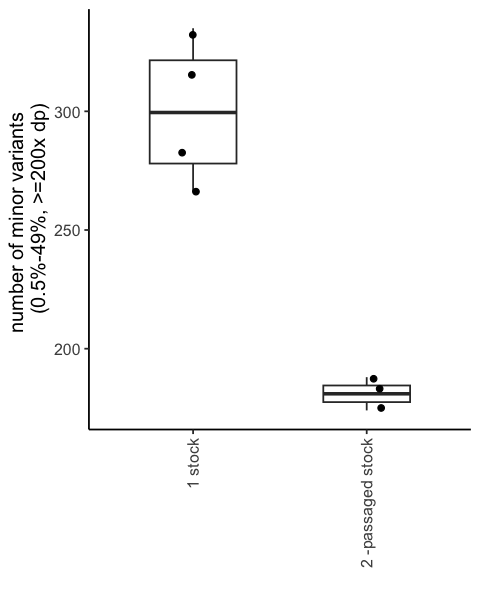

In [19]:
options(repr.plot.width = 4, repr.plot.height = 5)

print(p5)

ggsave(p5,
       filename = glue("{FIG_DIR}/stock.variants.png"),
       width = 3,
       height = 4, limitsize=FALSE)

ggsave(p5,
       filename = glue("{FIG_DIR}/stock.variants.pdf"),
       width = 3,
       height = 4, limitsize=FALSE, useDingbats = FALSE)

In [20]:
message("Total number of positions with a minor var across the 4 stock samples: ", nrow(stockvar_summary))
message("Number of minor var shared b/w all 4 stock samples: ", nrow(stockvar_summary %>% filter(sample_number == 4)))
message("Total number of positions with a minor var across the 3 passaged stock samples: ", nrow(pass_stockvar_summary))
message("Number of minor var shared b/w all 3 passaged stock samples: ", nrow(pass_stockvar_summary %>% filter(sample_number == 3)))
message("Number of minor var shared b/w at least one stock and one passaged stock sample: ", nrow(stockvar_summary %>% filter(ntpos %in% intersect(stockvar_summary$ntpos, pass_stockvar_summary$ntpos))))

Total number of positions with a minor var across the 4 stock samples: 341

Number of minor var shared b/w all 4 stock samples: 115

Total number of positions with a minor var across the 3 passaged stock samples: 154

Number of minor var shared b/w all 3 passaged stock samples: 99

Number of minor var shared b/w at least one stock and one passaged stock sample: 120



In [21]:
single_sites = levels(factor(c(c((stockvar_summary %>% filter(sample_number == 1))$ntpos), 
                                c((pass_stockvar_summary %>% filter(sample_number == 1))$ntpos)))
                     )

shared_sites = intersect(stockvar_summary$ntpos, pass_stockvar_summary$ntpos)


In [22]:
temp = rbind(stockvar %>% select(all_of(colnames(passaged_stockvar))), passaged_stockvar)

temp = temp %>% select(sample_name, ntpos, major, minor, minorfreq.x, minorfreq.y, totalcount.x, totalcount.y, minorfreq, totalcount) %>% unique() 

min((temp %>% filter(ntpos %in% shared_sites & !ntpos %in% single_sites))$minorfreq)

max((temp %>% filter(ntpos %in% shared_sites & !ntpos %in% single_sites))$minorfreq)

[1] 0.005187419

[1] 0.1746794

In [23]:
options(repr.plot.width = 4, repr.plot.height = 5)

p6 = ggplot() +
    geom_boxplot(data = temp %>% filter(ntpos %in% shared_sites &
                                       !ntpos %in% single_sites),
                aes(x='stock & passaged stock', y = minorfreq), width = 0.5) + 
    geom_boxplot(data = temp %>% filter(!ntpos %in% shared_sites &
                                       ntpos %in% single_sites),
                aes(x='single stock', y = minorfreq), width = 0.5) + 
    labs(x="", y = "frequency of minor variant (mean of seq replicates)") + 
    PlotTheme1



wilcox.test((temp %>% filter(ntpos %in% shared_sites &
                                       !ntpos %in% single_sites))$minorfreq,
      (temp %>% filter(!ntpos %in% shared_sites &
                                       ntpos %in% single_sites))$minorfreq)


	Wilcoxon rank sum test with continuity correction

data:  (temp %>% filter(ntpos %in% shared_sites & !ntpos %in% single_sites))$minorfreq and (temp %>% filter(!ntpos %in% shared_sites & ntpos %in% single_sites))$minorfreq
W = 55020, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


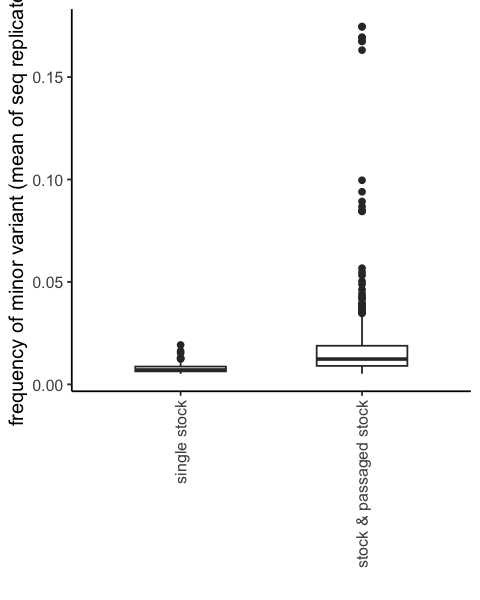

In [24]:
print(p6)

ggsave(p6,
       filename = glue("{FIG_DIR}/minorfreq.stock.variants.png"),
       width = 3,
       height = 5, limitsize=FALSE)

ggsave(p6,
       filename = glue("{FIG_DIR}/minorfreq.stock.variants.pdf"),
       width = 3,
       height = 5, limitsize=FALSE, useDingbats = FALSE)

## Filtering the stock variants using the minor freq cutoff and the total count (read depth) cutoffs:

In [25]:
# filter them for later if needed - but can still use the summary tables if needed
passaged_stockvar = passaged_stockvar %>% filter(!gene_id %in% orf_group &
                              minorfreq >= stock_minor_freq &
                              totalcount >= minor_cov &
                              binocheck == 'PASS') %>%
                        unique()

stockvar = stockvar %>% filter(!gene_id %in% orf_group &
                               minorfreq >= stock_minor_freq &
                              totalcount >= minor_cov & 
                              binocheck == 'PASS') %>%
                        unique()

## Coverage quality for mouse samples: 

Isolate samples: all 5 isolates had >90% genome coverage at 200x read depth for both replicates.

Mouse sample: All but Mouse 21 had >90% genome coverage at 200x, which had 78% and 80% coverage in each sequencing replicate. 

Turbinate samples had lower genome coverage compred to the other samples ranging at 87-92% frequency. 




In [26]:
# load in the first replicate sequences and pull out positions that are marked as being different
files1 = Sys.glob(glue("{wkdir}/reseq/r1/aasnplist/sample/*"), dirmark = FALSE)  # add the other samples here
sample_positions1 = prep_positions(files1, stock_con, major_cov, minor_cov, minor_freq, ntlist, aminoacids, nsps)
conlist1 = sample_positions1$conlist  # pulling out positions across all samples so we can use them as input to pull data again
minlist1 = sample_positions1$minlist
del_list1 = sample_positions1$del_list
del_minor1 = sample_positions1$del_minor

# use very lenient cutoffs now, then combine, and check
samples_df1 = prep_var_dfs(files1, stock_con, major_cov, 50, 0.01, c(conlist1, del_list1$ntpos), stockvar_summary, pass_stockvar_summary, c(minlist1, del_minor1$ntpos), ntlist)
consensus_df1 = samples_df1$consensus_df # this will be the same as CON
minor_df1 = samples_df1$minor_df

In [27]:
# combine the minor and major variant data into a long format
DF1 = rbind(consensus_df1, minor_df1)
DF1 = merge(DF1, meta, 
            by.x = c('name'), 
            by.y = c('r1'), all.x = TRUE) %>%
    filter(!gene_id %in% orf_group)

In [28]:
# load in and look at the second replicates:
files2 = Sys.glob(glue("{wkdir}/reseq/r2/aasnplist/sample/*"), dirmark = FALSE)
sample_positions2 = prep_positions(files2, stock_con, major_cov, minor_cov, minor_freq,ntlist, aminoacids, nsps)
conlist2 = sample_positions2$conlist
minlist2 = sample_positions2$minlist
del_list2 = sample_positions2$del_list
del_minor2 = sample_positions2$del_minor

samples_df2 = prep_var_dfs(files2, stock_con, major_cov, 50, 0.01, c(conlist2, del_list2$ntpos), stockvar_summary, pass_stockvar_summary, c(minlist2, del_minor2$ntpos), ntlist)
consensus_df2 = samples_df2$consensus_df
minor_df2 = samples_df2$minor_df

In [29]:
DF2 = rbind(consensus_df2, minor_df2)
DF2 = merge(DF2, meta, by.x = c('name'), by.y = c('r2'), all.x = TRUE) %>%
    filter(!gene_id %in% orf_group)

In [30]:
DF_ALL = merge(DF1 %>% select(all_of(selectit)), 
               DF2 %>% select(all_of(selectit)), 
               by = c(selectit[!selectit %in% c('totalcount','varfreq')]),
               all = TRUE)  %>%
        rowwise() %>%
        filter(varfreq.x >= minor_freq &
               varfreq.y >= minor_freq &
               totalcount.x >= major_cov &
               totalcount.y >= major_cov) %>% 
        mutate(varfreq = (varfreq.x + varfreq.y)/2,
               totalcount = (totalcount.x + totalcount.y)/2) %>%
        drop_na(varnt) %>% # ADDED
        ungroup() %>%
        group_by(sample_name, ntpos, gene_id, aapos) %>%
        add_tally() %>%
        # handling instances where the vars are ~50%
        mutate(vartype = ifelse(n > 1 & varfreq == max(varfreq), 'major',
                               ifelse(n==1 & varfreq > 0.50, 'major','minor'))) %>%
        ungroup() 


In [31]:
# i want to add the 'major' nt to all the positions so we can compare the minor variants to it
temp_maj = DF_ALL %>% 
    filter(vartype == 'major') %>%
    select(sample_name, gene_id, ntpos, aapos, varnt, varaa) %>%
    unique() %>%
    rename("majornt" = "varnt", 
           "majoraa" = "varaa") %>%
    unique()

In [32]:
DF_ALL = merge(DF_ALL, 
               temp_maj, 
               by = c('sample_name','gene_id','ntpos','aapos'), 
               all =TRUE) %>%
            rowwise() %>%
            #mutate(refnt = ifelse(vartype == 'major', refnt, refnt),
            #       refaa = ifelse(vartype == 'major', refaa, refaa)) %>%
            mutate(var_info = ifelse(vartype == 'major', glue("{refaa}{aapos}{varaa}"), 
                                     ifelse(vartype == 'minor', glue("{refaa}{aapos}{varaa}"),NA)),
                   
                  var_info_nt = ifelse(vartype == 'major', glue("{refnt}{ntpos}{varnt}"), 
                                       ifelse(vartype == 'minor', glue("{refnt}{ntpos}{varnt}"),NA)),
                   
                   VAR = glue("{ntpos}{varnt}"),
                   filter_flag = ifelse(vartype == 'major' & 
                                totalcount.x >= major_cov & 
                                totalcount.y >= major_cov &
                                varnt %in% ntlist, "PASS",
                        ifelse(vartype == 'minor' & 
                               totalcount.x >= minor_cov &
                              totalcount.y >= minor_cov &
                              varnt %in% ntlist &
                              varfreq.x >= sample_minor_freq &
                              varfreq.y >= sample_minor_freq, 'PASS', 'FAIL')))

In [33]:
DF_DEL = DF_ALL %>% filter(varnt == '-')

DF_ALL = DF_ALL %>% filter(varnt != '-')

DF_ALL$type = factor(DF_ALL$type, levels = sample_levels)

# Establishing standing vs. _de novo_ diversity

Consensus changes are those that are nucleotides differ from the stock virus consensus sequence and is present at 10x read depths. 

Standing diversity is diversity that is present in at least one stock sample. This is a very stringent cutoff. 

Minor variants in the sample have to be present at 2%-49% frequency at positions with at least 200x coverage. 

### Filtering DFs: 
- filter flag = pass
- varnt != refnt (refnt = stocknt)
- varnt in ntlist (AGCT)
- variant not in stockvar list

In [34]:
stockvar_summary = stockvar_summary %>%
                    rowwise() %>%
                    mutate(VAR = glue("{ntpos}{minor}"))

pass_stockvar_summary = pass_stockvar_summary %>%
                    rowwise() %>%
                    mutate(VAR = glue("{ntpos}{minor}"))


stockvar_list = levels(factor(c(stockvar_summary$VAR, pass_stockvar_summary$VAR)))


In [35]:
tally_consensus = DF_ALL %>% 
                    filter(filter_flag == 'PASS' &
                                        vartype == 'major' &
                                        varnt != refnt) %>%
                    unique() %>%
                    group_by(ntpos, gene_id, varnt, refnt, passaged_refnt, 
                             aapos, varaa, refaa, var_info, var_info_nt, vartype, type) %>%
                    tally(name = 'consensus_count') %>%
                    mutate(total = sum(consensus_count)) %>%
                    ungroup() %>%
                    pivot_wider(names_from = 'type', values_from = 'consensus_count', values_fill = 0) %>%
                    unique() %>%
                    rowwise() %>%
                    mutate(VAR = glue("{ntpos}{varnt}")) %>%
                    ungroup() 

In [36]:
standing_consensus = tally_consensus %>% filter(VAR %in% stockvar_list) %>% unique()

denovo_consensus = tally_consensus %>% filter(!VAR %in% stockvar_list) %>% unique()

## Consensus changes



In [37]:
temp = DF_ALL %>% 
        filter(var_info_nt %in% (denovo_consensus %>% filter(sample == 1))$var_info_nt) %>%
        select(vartype, ntpos, var_info_nt) %>%
        unique() %>%
        group_by(var_info_nt, ntpos) %>%
        tally()

true_singletons = temp %>% filter(n == 1)

as_minors = temp %>% filter(n > 1)

In [38]:
isolate_changes = denovo_consensus %>% filter(sample == 0)
isolate_changes

ntpos,gene_id,varnt,refnt,passaged_refnt,aapos,varaa,refaa,var_info,var_info_nt,vartype,total,sample,isolate,VAR
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<glue>
9935,nsp4,G,A,A,461,A,T,T461A,A9935G,major,1,0,1,9935G
16474,nsp13,G,A,A,80,G,S,S80G,A16474G,major,1,0,1,16474G
26353,E,T,C,C,37,F,L,L37F,C26353T,major,1,0,1,26353T


## Characteristics of de novo consensus changes

Consensus change = the nucleotide at a given position in a sample is different from the stock nt
de novo = Not present in the standing diversity of the stock (not present as a minor variant) - may be present below our limit of detection. 


In [39]:
# CONSENSUS/MAJORA = denovo df
denovo_DF = DF_ALL %>% filter(filter_flag == 'PASS' &
                                    vartype == 'major' &
                                    varnt != refnt &
                              VAR %in% denovo_consensus$VAR &
                             !VAR %in% isolate_changes$VAR) %>%
                             
    mutate(nonsyn = ifelse(varaa != refaa, 'nonsyn','syn')
          ) %>%
    unique()

In [40]:
# number of consensus changes / sample
denovo_DF %>%
        group_by(sample_name, mouse_id,sample_id, type) %>%
        tally() %>%
    arrange(n)

sample_name,mouse_id,sample_id,type,n
<chr>,<chr>,<chr>,<fct>,<int>
KAF_109_25,25,25_sample,sample,1
KAF_109_21,21,21_sample,sample,5
KAF_109_26,26,26_sample,sample,6
isolate_26,26,26_isolate,isolate,6
KAF_109_22,22,22_sample,sample,7
KAF_109_23,23,23_sample,sample,7
KAF_109_27,27,27_sample,sample,7
isolate_27,27,27_isolate,isolate,7
KAF_109_24,24,24_sample,sample,8


## Looking at the general characteristics of mutations across all de novo variants (consensus changes + minor variants)


In [41]:
p200 = read.csv(glue("{wkdir}/metadata/mehul.p200.cov.csv"), header = TRUE)

In [42]:
denovo_all = DF_ALL %>% filter(filter_flag == 'PASS' &
                                    vartype == 'major' &
                                    varnt != refnt &
                                    varnt %in% ntlist &
                                    !VAR %in% stockvar_list | 
                        
                        filter_flag == 'PASS' &
                                    vartype == 'minor' &
                                    varnt %in% ntlist &
                                    varnt != refnt &
                                    !VAR %in% stockvar_list) %>% 
          
            
            mutate(gene_id = ifelse(gene_id %in% gene_list, gene_id, NA), 
                nonsyn = ifelse(!gene_id %in% c(coding_list, nsps),
                                   'non-coding',       
                            ifelse(gene_id %in% c(coding_list, nsps) &
                                   varaa == refaa &
                                   varaa %in% aminoacids,
                                  'syn',
                            ifelse(gene_id %in% c(coding_list, nsps) &
                                  varaa != refaa &
                                  varaa %in% aminoacids &
                                   varaa != '*',
                                  'nonsyn',
                            ifelse(gene_id %in% c(coding_list, nsps) &
                                  varaa != refaa &
                                   varaa == '*',
                                  'nonsense', 
                            ifelse(varnt == '-', 'del', NA)))))) %>%
            unique()

denovo_all$gene_id[is.na(denovo_all$gene_id)] = 'INTERGENIC'

In [43]:
denovo_table = denovo_all %>% filter(type == 'sample' & filter_flag == 'PASS') %>% 
    mutate(var_info = glue("{gene_id}: {var_info}"),
           var_info_nt = glue("{gene_id}: {var_info_nt}"), 
          mouse_id2 = as.numeric(as.character(mouse_id2)) - 20) %>% 
    arrange(mouse_id2, ntpos) %>%
    select(mouse_id2,var_info, var_info_nt, nonsyn, varfreq) %>%
    unique()

write.csv(denovo_table, 
         glue("{wkdir}/metadata/denovo.table.csv"),
         row.names= FALSE)

In [44]:
gene_info = read.csv(glue('{wkdir}/../../reference/sars/sars_nih_ref/sars-cov-2-features.5.csv')) 
gene_info$gene_length = (gene_info$END - gene_info$START + 1)/1000

In [45]:
# calculating avg #/kb for each gene region
temp_table = denovo_all %>% filter(type == 'sample' & filter_flag == 'PASS') %>% 
    mutate(var_info = glue("{gene_id}: {var_info}"),
           var_info_nt = glue("{gene_id}: {var_info_nt}"), 
          mouse_id2 = as.numeric(as.character(mouse_id2)) - 20) %>% 
    arrange(mouse_id2, ntpos) %>%
    select(mouse_id2,var_info, var_info_nt, nonsyn, varfreq, gene_id) %>%
    unique() %>%
    group_by(mouse_id2, gene_id) %>%
    tally() %>%
    pivot_wider( names_from = 'gene_id', values_from = 'n', values_fill = 0) %>%
    pivot_longer(!c('mouse_id2'), names_to = 'gene_id', values_to = 'n') %>%
    unique()



merge(gene_info %>% select(NAME, gene_length) %>% rename('gene_id' = 'NAME'),
      temp_table, by = 'gene_id', all.y = TRUE) %>%
    mutate(perkb = n/gene_length) %>%
    group_by(gene_id) %>%
    mutate(mean_perkb = mean(perkb),
          sd_perkb = sd(perkb),
          total = sum(n)) %>%
    select(-mouse_id2, -n, -perkb) %>%
    unique() %>%
    arrange(mean_perkb)

gene_id,gene_length,mean_perkb,sd_perkb,total
<chr>,<dbl>,<dbl>,<dbl>,<int>
S,3.822,0.07849294,0.1263856,3
nsp3,5.835,0.08568980,0.1665510,5
nsp5,0.918,0.10893246,0.3444747,1
nsp16,0.897,0.11148272,0.3525393,1
ORF3a,0.828,0.12077295,0.3819176,1
nsp14,1.581,0.12650221,0.2666901,2
nsp2,1.914,0.15673981,0.2523751,3
nsp12b,2.769,0.18057060,0.2553654,5
nsp1,0.540,0.18518519,0.5856070,1


In [46]:
stock_check = DF_ALL %>% filter(type == 'stock' & ntpos %in% denovo_all$ntpos) %>%
    select(gene_id, ntpos, aapos, varnt, varaa, varcodon) %>%
    unique()

write.csv(stock_check, 
         glue("{wkdir}/metadata/check.stock.csv"),
         row.names= FALSE)

In [47]:
genes_df = read.csv(glue("{wkdir}/metadata/mehul.genes_df.csv"), header = TRUE) 

In [48]:
genes_filt = genes_df %>% 
    select(-sample_name, -name.x, -name.y) %>%
    unique() %>%
    group_by(gene_id) %>%
    add_tally(name = 'size') %>%
    ungroup() %>%
    select(gene_id, size, gene_start, gene_end) %>% 
    unique() %>%
    filter(gene_id %in% gene_ord_list)


In [49]:
arrange_nonsyn = c('non-coding','syn','nonsyn','nonsense')
denovo_all$nonsyn = factor(denovo_all$nonsyn, levels = arrange_nonsyn)
p30 = denovo_all %>%
        filter(type == 'sample' & filter_flag == 'PASS') %>% 
    ggplot(., aes(x=nonsyn, fill = vartype)) +
    geom_bar(color = 'black') +
    PlotTheme1 +
    scale_y_continuous(breaks=seq(0,10,2)) +
    scale_fill_manual(values = c('#616066', 'lightgray')) + 
    facet_grid(.~glue("{as.numeric(mouse_id2)}"), scales = 'free_y', space = 'free')



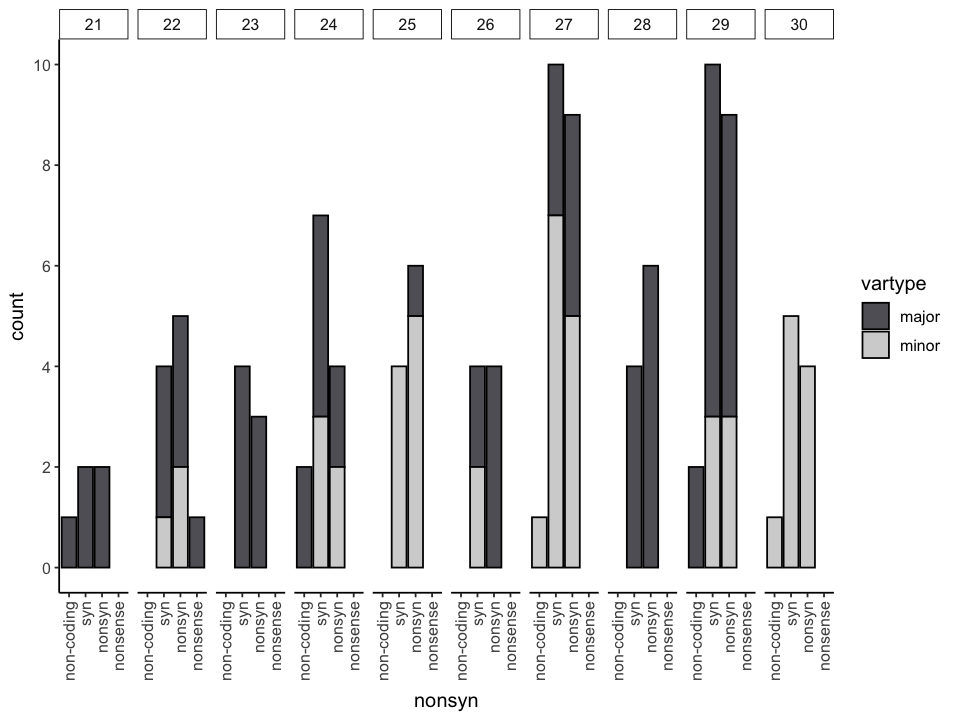

In [50]:
options(repr.plot.width = 8, repr.plot.height = 6)

print(p30)

ggsave(p30,
       filename = glue("{FIG_DIR}/denovo.counts.all.png"),
       width = 7,
       height = 4, limitsize=FALSE)

ggsave(p30,
       filename = glue("{FIG_DIR}/denovo.counts.all.pdf"),
       width = 7,
       height = 4, limitsize=FALSE, useDingbats = FALSE)

In [51]:
denovo_all %>%
        filter(type == 'sample' ) %>% 
    group_by(sample_id2) %>%
    tally() %>%
    arrange(n)

sample_id2,n
<chr>,<int>
21_sample,5
23_sample,7
26_sample,8
22_sample,10
25_sample,10
28_sample,10
30_sample,10
24_sample,13
27_sample,20


In [52]:
p25 = denovo_all %>%
    filter(type %in% c('sample','turbinate')) %>%
    ggplot(., aes(x=varfreq, y = ..count../sum(..count..), fill = type)) + 
    geom_histogram(color = 'black') + 
    scale_fill_manual(values = c('black','gray')) + 
    labs(x='de novo var freq',y='density of de novo vars') + 
    PlotTheme1



Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


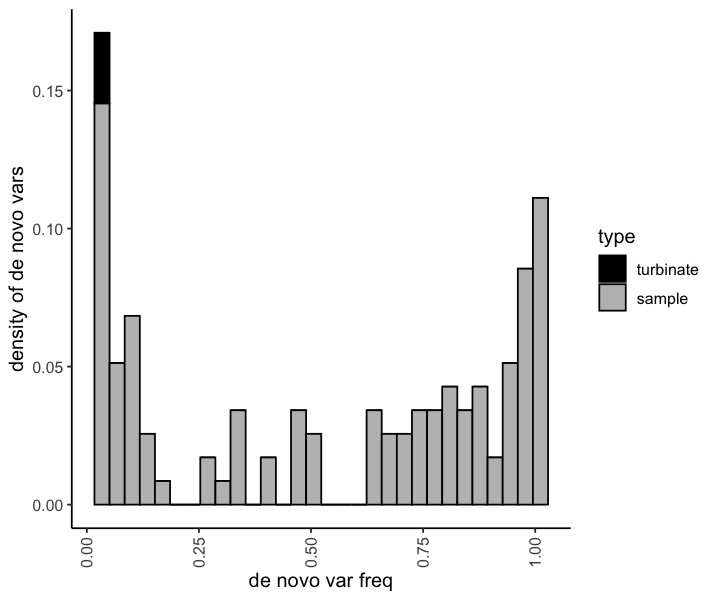

In [53]:
options(repr.plot.width = 6, repr.plot.height = 5)

ggsave(p25,
       filename = glue("{FIG_DIR}/denovo.var.freq.histo.png"),
       width = 5,
       height = 4, limitsize=FALSE)

ggsave(p25,
       filename = glue("{FIG_DIR}/denovo.var.freq.histo.pdf"),
       width = 5,
       height = 4, limitsize=FALSE, useDingbats = FALSE)

print(p25)

In [54]:
# total nonsyn vs. syn by mouse and PER MOUSE
temp = denovo_all %>%
        group_by(sample_name, nonsyn, type, type2, mouse_id, sample_id) %>%
    tally(name = 'nonsyn_count')

total_counts = merge(temp,  
             p200 %>% filter(!type %in% c('stock','passaged_stock')), by = c('sample_name', 'type', 'type2', 'sample_id'), all.y = TRUE) %>%
    pivot_wider(names_from = nonsyn, values_from = nonsyn_count, values_fill = 0) %>%
    pivot_longer(c('nonsyn','syn', "NA"), names_to = 'nonsyn', values_to = 'nonsyn_count') %>%
    filter(nonsyn != "NA") %>%
    unique()


In [55]:
temp = denovo_all %>%
        group_by(sample_name, nonsyn, type, type2, mouse_id, sample_id2, sample_id) %>%
        mutate(divergence = sum(varfreq)) %>%
        select(sample_name, nonsyn, type, type2, mouse_id, sample_id2, sample_id, divergence) %>%
    unique()

temp = merge(temp,  
             p200 %>% 
             filter(!type %in% c('stock','passaged_stock')),
             by = c('sample_name', 'type', 'type2', 'sample_id'), 
             all.y = TRUE) %>%
    filter(nonsyn %in% c('nonsyn','syn')) %>%
    pivot_wider(names_from = nonsyn, values_from = divergence, values_fill = 0) %>%
    pivot_longer(c('nonsyn','syn'), names_to = 'nonsyn', values_to = 'divergence') %>%
    mutate(norm_div = ifelse(nonsyn == 'syn', divergence/(mean_est_syn), divergence/(mean_est_nonsyn))) %>%
    select(nonsyn, sample_name, divergence, norm_div, mouse_id, type, sample_id, sample_id2, type2) %>%
    unique() 


temp = temp %>% filter(type %in% c('sample','turbinate')) %>%
                 mutate(day = ifelse(type == 'sample', 28, 3))

temp$perday = temp$norm_div/temp$day

In [56]:
p18 = ggplot(temp, aes(x=nonsyn, y =perday, color = sample_id2)) + 
    geom_boxplot(width = 0.5, color = 'black') + 
    geom_point(width = 0.2, aes(shape = type2), size =2) + 
    geom_line(aes(group = sample_id2), linewidth=0.2) + 
    PlotTheme1 +
    sample_colScale + 
    type_shapes + 
    labs(y='divergence/site/day') +  # all de novo (consensus + minor)
    facet_grid(.~type2, scales = 'free', space = 'free') 

Warning message in geom_point(width = 0.2, aes(shape = type2), size = 2):
“Ignoring unknown parameters: `width`”


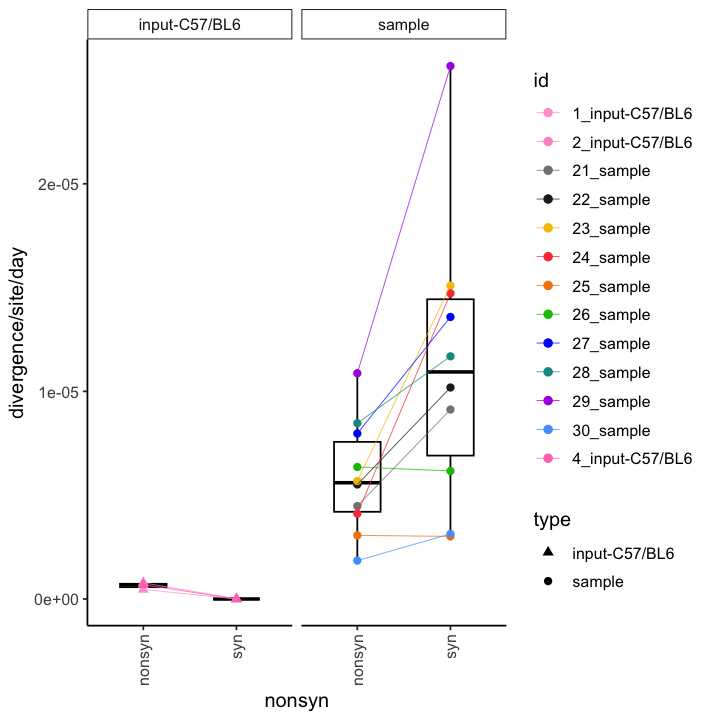

In [57]:
options(repr.plot.width = 6, repr.plot.height = 6)
print(p18)

ggsave(p18,
       filename = glue("{FIG_DIR}/denovo.divergence.sample.nonsyn.lines.png"),
       width = 5,
       height = 4, limitsize=FALSE)

ggsave(p18,
       filename = glue("{FIG_DIR}/denovo.divergence.sample.nonsyn.lines.pdf"),
       width = 5,
       height = 4, limitsize=FALSE, useDingbats = FALSE)

In [58]:
# calculate mean and median divergence
temp %>%
    group_by(type, day,nonsyn) %>%
    mutate(mean = mean(perday),
          median = median(perday)) %>%
    select(type, day, mean, median, nonsyn) %>%
    unique()


type,day,mean,median,nonsyn
<fct>,<dbl>,<dbl>,<dbl>,<chr>
sample,28,5.836887e-06,5.599426e-06,nonsyn
sample,28,1.123880e-05,1.093681e-05,syn
turbinate,3,6.400061e-07,6.839886e-07,nonsyn
turbinate,3,0.000000e+00,0.000000e+00,syn


In [59]:
for_stats = temp %>% filter(type %in% c('sample')) %>%
    select(-divergence, -norm_div) %>%
    pivot_wider(names_from = "nonsyn", values_from = 'perday')

#for_stats
mean(for_stats$nonsyn)
mean(for_stats$syn)

message("this")
mean(for_stats$syn)/mean(for_stats$nonsyn)

median(for_stats$nonsyn)
median(for_stats$syn)
wilcox.test(for_stats$nonsyn, for_stats$syn)

[1] 5.836887e-06

[1] 1.12388e-05

this



[1] 1.925479

[1] 5.599426e-06

[1] 1.093681e-05


	Wilcoxon rank sum exact test

data:  for_stats$nonsyn and for_stats$syn
W = 23, p-value = 0.04326
alternative hypothesis: true location shift is not equal to 0


In [60]:
# transition vs. transversion counts

p21 = denovo_all %>%
    select(sample_name, ntpos, varnt, refnt) %>%
    unique() %>%
    group_by(varnt, refnt) %>%
    tally() %>%
    ungroup() %>%
    pivot_wider(names_from = refnt, values_from = n, values_fill = 0) %>%
    pivot_longer(cols = !varnt, values_to = 'n', names_to = 'refnt') %>%
    mutate(total = sum(n),
          frac = n/total) %>%
    ungroup() %>%
    ggplot(., aes(x=varnt, y=refnt, fill = frac)) +
    geom_tile(color = 'black') + 
    PlotTheme1 +
    labs(x='mutation nt', fill = 'density', 
         y='stock nt', title = 'transitions vs. transversions for de novo changes (all)') +
    scale_fill_continuous(low = 'white', high='#0267a5')


ggsave(p21,
       filename = glue("{FIG_DIR}/denovo.tn.ts.png"),
       width = 4,
       height = 3.5, limitsize=FALSE)

ggsave(p21,
       filename = glue("{FIG_DIR}/denovo.tn.ts.pdf"),
       width = 4,
       height = 3.5, limitsize=FALSE, useDingbats = FALSE)

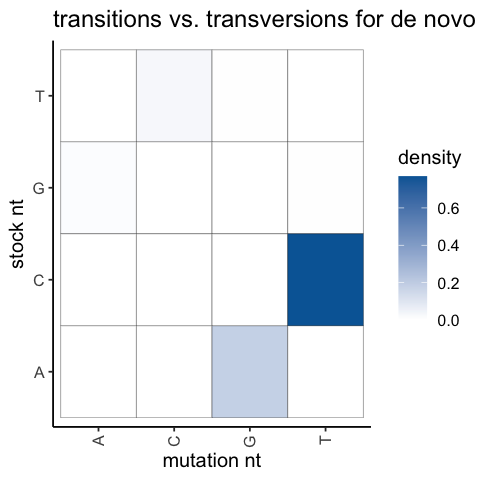

In [61]:
options(repr.plot.width = 4, repr.plot.height = 4)

print(p21)

In [62]:
denovo_all %>%
    select(sample_name, ntpos, refnt, varnt) %>%
    unique() %>%
    group_by(refnt,varnt) %>%
    tally() %>%
    ungroup() %>%
    pivot_wider(names_from = refnt, values_from = n, values_fill = 0) %>%
    pivot_longer(cols = !varnt, values_to = 'n', names_to = 'refnt') %>%
    mutate(total = sum(n),
          frac = n/total) %>%
    ungroup() %>%
    unique() %>% 
    arrange(frac)

varnt,refnt,n,total,frac
<chr>,<chr>,<int>,<int>,<dbl>
G,C,0,182,0.000000000
G,G,0,182,0.000000000
T,A,0,182,0.000000000
T,T,0,182,0.000000000
A,A,0,182,0.000000000
A,C,0,182,0.000000000
A,T,0,182,0.000000000
C,A,0,182,0.000000000
C,C,0,182,0.000000000


In [63]:
varcount = denovo_all %>%
             filter(varnt != refnt) %>%
             group_by(VAR,refnt, gene_id, type, ntpos) %>%
            tally(name = 'var_count') %>% 
            pivot_wider(names_from ='type', values_from = 'var_count', values_fill = 0) %>%
            mutate(total_samples = sample + turbinate)

In [64]:
denovo_all %>% filter(ntpos %in% (varcount %>% filter(total_samples > 1))$ntpos &
                      varaa %in% aminoacids &
                      refaa %in% aminoacids & 
                      refaa != varaa) %>%
    select(ntpos, gene_id, var_info) %>% 
    unique()

ntpos,gene_id,var_info
<int>,<chr>,<chr>
26333,E,T30I
14524,nsp12b,H353Y
29670,ORF10,T38I
12596,nsp8,L169F
20396,nsp15,K259R
9438,nsp4,T295I
7173,nsp3,S1485F
12008,nsp7,L56F


# Used for the supp table: 

In [65]:
denovo_all %>% filter(ntpos %in% (varcount %>% filter(total_samples > 1))$ntpos) %>%
    mutate(gene_var = ifelse(varaa %in% aminoacids, glue("{gene_id}: {var_info}"), glue("{gene_id}: {var_info_nt}"))) %>%
    filter(type2 %in% c('sample','input-C57/BL6')) %>%
    unique() %>%
    group_by(gene_var,type2) %>%
    add_tally(name = 'varcount') %>%
    select(gene_id, ntpos, gene_var,type2, varcount) %>%
    unique() %>%
    pivot_wider(names_from = 'type2', values_from = 'varcount', values_fill = 0) %>%
    arrange(ntpos)


denovo_all %>% filter(ntpos %in% (varcount %>% filter(total_samples > 1))$ntpos) %>%
    mutate(gene_var = ifelse(varaa %in% aminoacids, glue("{gene_id}: {var_info}"), glue("{gene_id}: {var_info_nt}"))) %>%
    filter(varfreq >= 0.50 & type2 %in% c('sample','input-C57/BL6')) %>%
    unique() %>%
    group_by(gene_var,type2) %>%
    add_tally(name = 'varcount') %>%
    select(gene_id, ntpos, gene_var,type2, varcount, var_info_nt) %>%
    unique() %>%
    pivot_wider(names_from = 'type2', values_from = 'varcount', values_fill = 0) %>%
    arrange(ntpos)

gene_id,ntpos,gene_var,sample,input-C57/BL6
<chr>,<int>,<chr>,<int>,<int>
nsp3,7173,nsp3: S1485F,2,0
nsp4,9430,nsp4: I292I,7,0
nsp4,9438,nsp4: T295I,3,0
nsp4,9745,nsp4: Y397Y,2,0
nsp6,11620,nsp6: F216F,3,0
nsp7,12008,nsp7: L56F,1,1
nsp7,12073,nsp7: D77D,6,0
nsp8,12367,nsp8: F92F,2,0
nsp8,12596,nsp8: L169F,7,0


gene_id,ntpos,gene_var,var_info_nt,sample
<chr>,<int>,<chr>,<chr>,<int>
nsp3,7173,nsp3: S1485F,C7173T,1
nsp4,9430,nsp4: I292I,C9430T,3
nsp4,9438,nsp4: T295I,C9438T,2
nsp4,9745,nsp4: Y397Y,C9745T,1
nsp6,11620,nsp6: F216F,C11620T,1
nsp7,12008,nsp7: L56F,C12008T,1
nsp7,12073,nsp7: D77D,C12073T,1
nsp8,12367,nsp8: F92F,C12367T,1
nsp8,12596,nsp8: L169F,C12596T,4


In [66]:
options(repr.plot.width = 15, repr.plot.height = 6)
p24 = ggplot() + 
    geom_vline(data = denovo_all %>% 
               filter(ntpos %in% (varcount %>% filter(total_samples > 1))$ntpos), 
               aes(xintercept = ntpos), color = 'lightgray', linetype = 2 ) + 

    geom_point(data = denovo_all %>% filter(varnt != refnt & type != 'isolate'), 
                   aes(x= ntpos, y = varfreq, color = nonsyn, shape = type2),
              size = 2) + 

    geom_text(data = denovo_all %>% filter(ntpos %in% (varcount %>% filter(total_samples > 1))$ntpos &
                                          varaa %in% aminoacids &
                                          refaa %in% aminoacids &
                                          varaa != refaa) %>%
                        select(ntpos, gene_id, var_info) %>% 
                        unique(),
              aes(x = ntpos, y = 1.25, label = glue("{gene_id}: {var_info}")), angle = 90, size = 3) + 

    PlotTheme1 + 
    geom_gene_arrow(data = gene_info %>% filter(!NAME %in% nsps) , 
               aes(xmin = START, xmax = END, y = 1.1, fill = NAME)) +
    gene_colScale_fill + 
    type_shapes + 
    scale_color_manual(values = c('black','black', 'red','red')) + 
    labs(y="variant frequency", x= 'ntpos') + 
    PlotTheme1



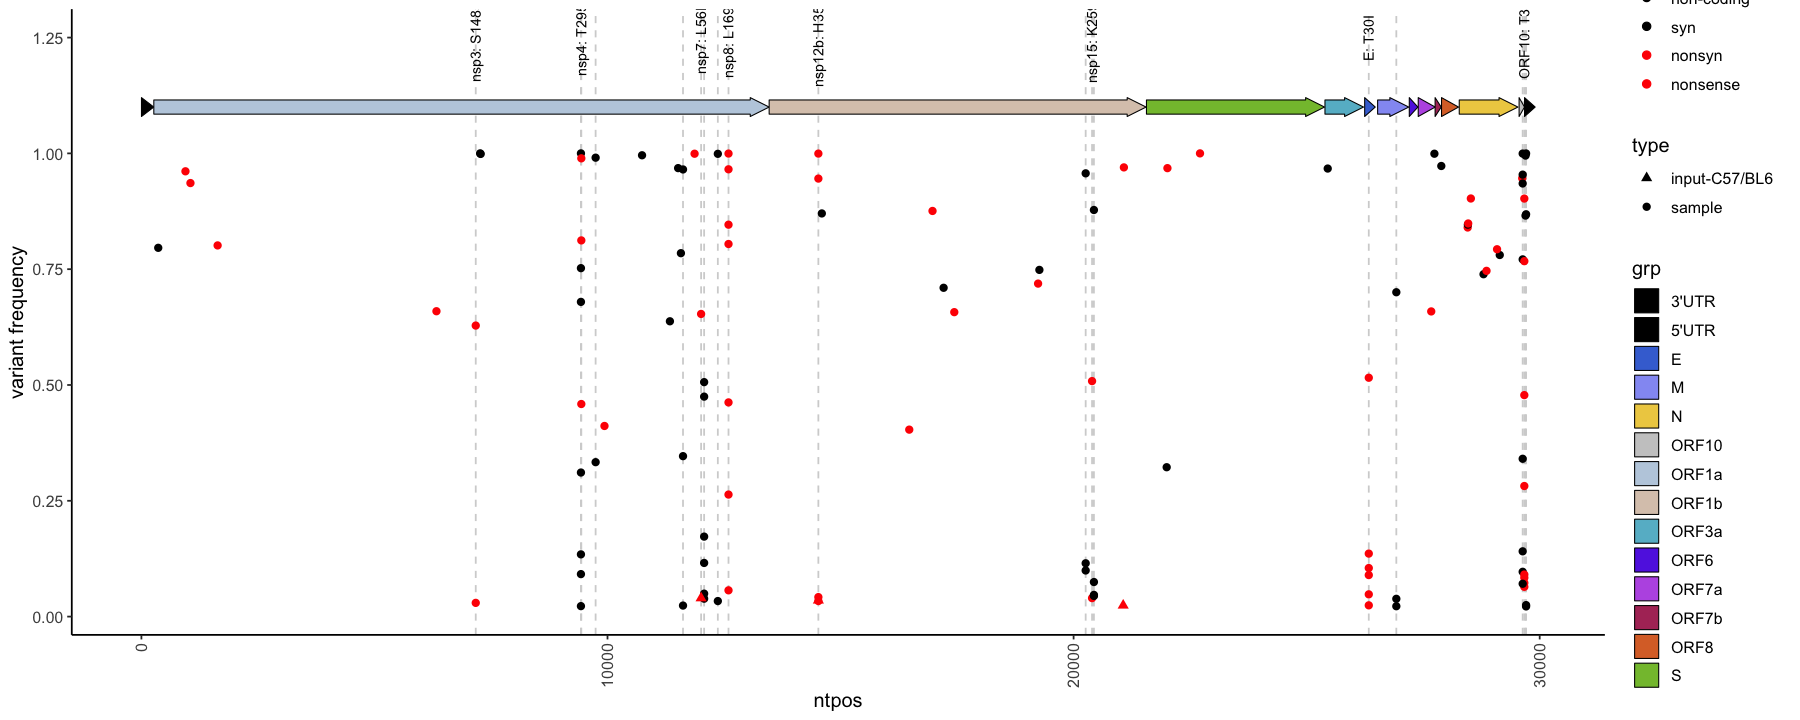

In [67]:
p24
ggsave(p24,
       filename = glue("{FIG_DIR}/denovo.location.png"),
       width = 10,
       height = 4, limitsize=FALSE)

ggsave(p24,
       filename = glue("{FIG_DIR}/denovo.location.pdf"),
       width = 10,
       height = 4, limitsize=FALSE, useDingbats = FALSE)

In [68]:
temp_m = denovo_all %>% filter(varnt != refnt & type != 'isolate') %>%
    mutate(shared = ifelse(ntpos %in% (varcount %>% filter(total_samples > 1))$ntpos, 'yes','no'),
          freq_type = ifelse(varfreq >= 0.50, 'high','low')) %>%
    select(var_info_nt, freq_type, shared) %>% 
    unique() %>%
    group_by(freq_type, shared) %>%
    tally() %>%
    pivot_wider(names_from = freq_type, values_from = n, values_fill = 0)


temp_m = temp_m %>%
    select(-shared) %>%
    unique() %>%
    as.matrix()

rownames(temp_m) = c('no','yes')

temp_m
fisher.test(temp_m)


,high,low
no,34,4
yes,19,18



	Fisher's Exact Test for Count Data

data:  temp_m
p-value = 0.0003415
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  2.15705 36.44894
sample estimates:
odds ratio 
  7.816657 


# Genetic distance of samples:

In [69]:
# Filtering for positions that could be pulled for all samples
compare_sites = DF_ALL %>%
    select(sample_name, ntpos) %>%
    unique() %>% 
    group_by(ntpos) %>%
    tally() %>% unique() %>%
    filter(n == 27)

In [70]:
DF_ALL$ntvar = paste0(DF_ALL$ntpos, DF_ALL$varnt) 
dist_temp = DF_ALL %>% 
            filter(ntpos %in% compare_sites$ntpos) %>%
            select(sample_name, ntvar, varfreq) %>%
            unique() %>%
            pivot_wider(names_from = 'ntvar', values_from = 'varfreq', values_fill = 0) %>%
            unique() %>%
            as.data.frame()

rownames(dist_temp) = dist_temp$sample_name
dist_temp = dist_temp %>% select(-sample_name)
d = dist(dist_temp, method = 'manhattan', diag=T, upper=T)
fit <- cmdscale(d, eig=TRUE, k=2) # generates a list of various things

fit2 = as.data.frame(fit$points)
fit2$sample_name = rownames(dist_temp)
fit2 = merge(fit2, meta, by = c('sample_name')) %>%
    rowwise() %>%
    mutate(mouse_numb = gsub("KAF_109_","",sample_name))



In [71]:
fit2 = fit2 %>% mutate(mouse_id = gsub("isolate_", "", mouse_numb),
                      mouse_id = ifelse(type %in% c('passaged_stock','stock', 'turbinate'), type, mouse_id),
                      mouse_id2 = ifelse(mouse_id == 'passaged_stock','input-vero',
                                    ifelse(mouse_id == 'stock', 'input', 
                                          ifelse(mouse_id == 'turbinate', 'input-c57/bl6', mouse_id))))


fit2$sample_id2 = factor(fit2$sample_id2, levels = sample_labels)

In [72]:
options(repr.plot.width = 8, repr.plot.height = 6)
p23 = ggplot(fit2, aes(x=V1, y= V2, color = sample_id2
                      )) +
    geom_point(size = 3, aes(shape = type2)) +
    labs(x="mds1",y='mds2') + 
    sample_colScale + 
    type_shapes +
    PlotTheme1 

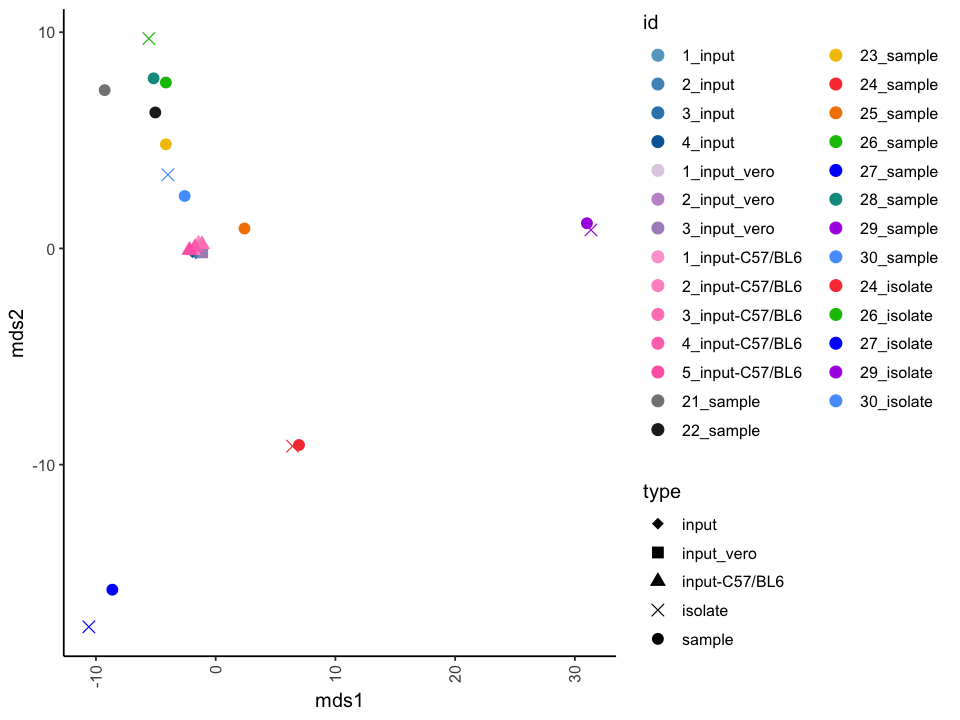

In [73]:
options(repr.plot.width = 8, repr.plot.height = 6)

print(p23)

In [74]:
ggsave(p23,
       filename = glue("{FIG_DIR}/dist.all.png"),
       width = 7,
       height = 4, limitsize=FALSE)

ggsave(p23,
       filename = glue("{FIG_DIR}/dist.all.pdf"),
       width = 7,
       height = 4, limitsize=FALSE, useDingbats = FALSE)

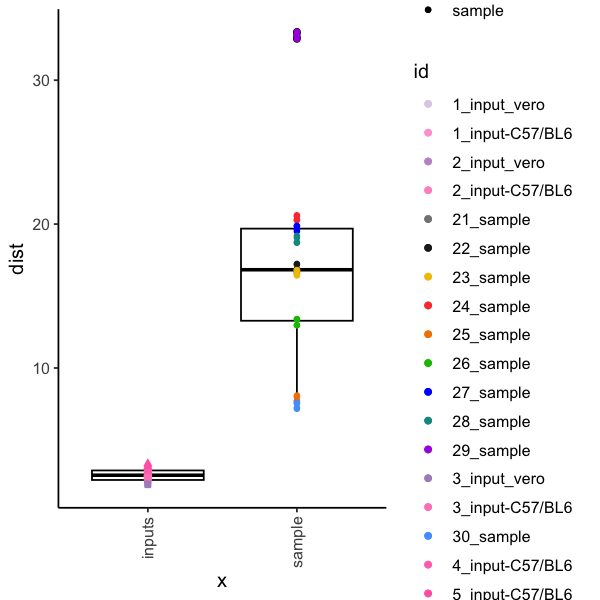

In [75]:
# COMPARISON OF DIVERGENCE BETWEEN CONTROLS AND INPUT AND MOUSE SAMPLES AND STOCK INPUT
tempd = d %>% as.matrix() %>% as.data.frame()
tempd$sample_name = rownames(tempd)
tempd = tempd %>% pivot_longer(!c("sample_name"), names_to = 'name2', values_to = 'dist')

tempd = merge(merge(tempd, meta %>% select(sample_name, sample_id2, mouse_id2, type2),  # merge to metadata
                  by = c('sample_name')) %>% # by sample name
                rename("sample_id"="sample_id2",
                      "mouse_id" = "mouse_id2", "type" = "type2"), # rename these just so we have 1 and 2

                  meta %>% select(sample_name, sample_id2, mouse_id2, type2),  # merge to metadata
                      by.x = c('name2'),
                      by.y = c('sample_name')) %>%
    filter(type %in% c('input')) %>% #,'input_vero','input-C57/BL6')) %>%
    unique()

options(repr.plot.width = 5, repr.plot.height = 5)



ggplot() +
    geom_boxplot(data = tempd %>% filter(sample_name != name2 &
                                         type2 %in% c('input_vero','input-C57/BL6')), 
                               aes(x="inputs", y = dist), color = 'black') + 
    geom_point(data = tempd %>% filter(sample_name != name2 &
                                       type2 %in% c('input_vero','input-C57/BL6')), 
                               aes(x="inputs", y = dist, color = sample_id2, shape = type2)) +

    geom_boxplot(data = tempd %>% filter(type2 %in% c('sample')), 
                               aes(x=type2, y = dist), color = 'black') + 
    geom_point(data = tempd %>% filter(type2 %in% c('sample')), 
                               aes(x=type2, y = dist, color = sample_id2, shape = type2)) +
    PlotTheme1 + 
    sample_colScale + 
    type_shapes

In [76]:
wilcox.test((tempd %>% filter(sample_name != name2 &
                                       type2 %in% c('input_vero','input-C57/BL6')))$dist,
            
           (tempd %>% filter(sample_name != name2 &
                                       type2 %in% c('sample')))$dist)


	Wilcoxon rank sum exact test

data:  (tempd %>% filter(sample_name != name2 & type2 %in% c("input_vero", "input-C57/BL6")))$dist and (tempd %>% filter(sample_name != name2 & type2 %in% c("sample")))$dist
W = 0, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [77]:
tempd %>%
    filter(type2 == 'sample') %>%
    select(mouse_id2, dist, sample_id) %>%
    group_by(mouse_id2) %>%
    mutate(mean_dist = mean(dist)) %>%
    select(mouse_id2, mean_dist) %>%
    arrange(mean_dist) %>%
    unique()

mouse_id2,mean_dist
<chr>,<dbl>
30,7.375948
25,7.864951
26,13.183595
23,16.617731
21,16.725178
22,17.020024
28,18.916733
27,19.714022
24,20.429306


In [78]:
p23 = ggplot(fit2 %>% filter(type %in% c('passaged_stock','stock', 'turbinate')), 
             aes(x=V1, y= V2, color = sample_id2)) +
    geom_point(size = 5, aes(shape = type2)) +
    labs(x="mds1",y='mds2') + 
    sample_colScale + 
    type_shapes + 
    PlotTheme1 

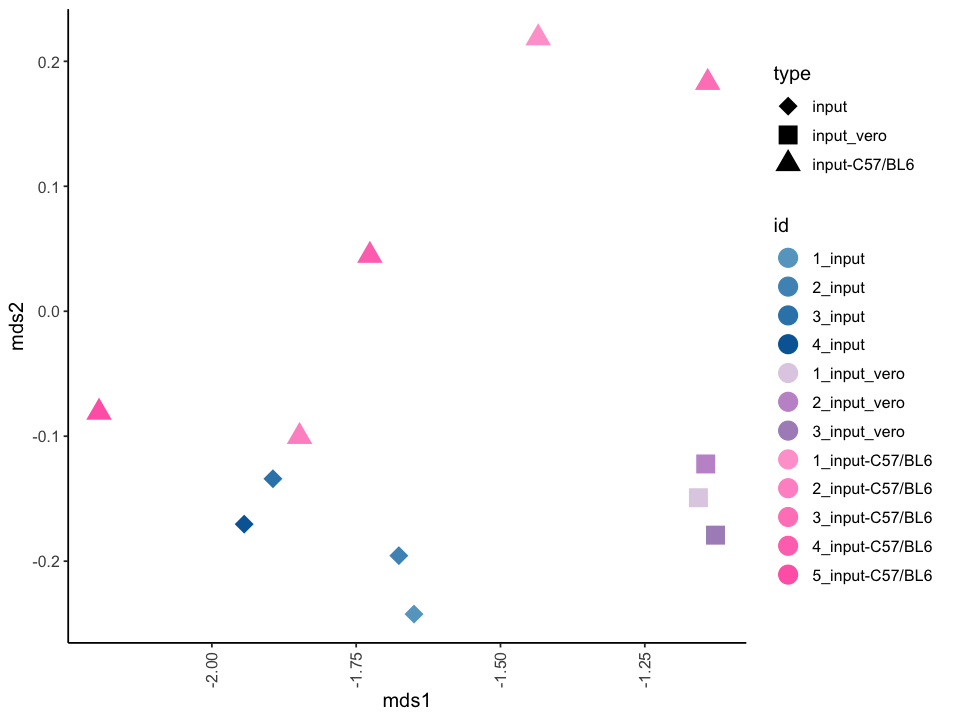

In [79]:
options(repr.plot.width = 8, repr.plot.height = 6)

print(p23)

ggsave(p23,
       filename = glue("{FIG_DIR}/dist.inputs.only.png"),
       width = 6,
       height = 4, limitsize=FALSE)

ggsave(p23,
       filename = glue("{FIG_DIR}/dist.inputs.only.pdf"),
       width = 6,
       height = 4, limitsize=FALSE, useDingbats = FALSE)

# Isolate information for mice: 
24, 26, 27, 29, 30

In [80]:
isolate_mice = c(24, 26, 27, 29, 30)

DF_TEMP_ALL = rbind(denovo_all %>% filter(mouse_id %in% isolate_mice) %>% select(all_of(colnames(DF_DEL))),
                   DF_DEL %>% filter(mouse_id %in% isolate_mice)) %>%
        unique()

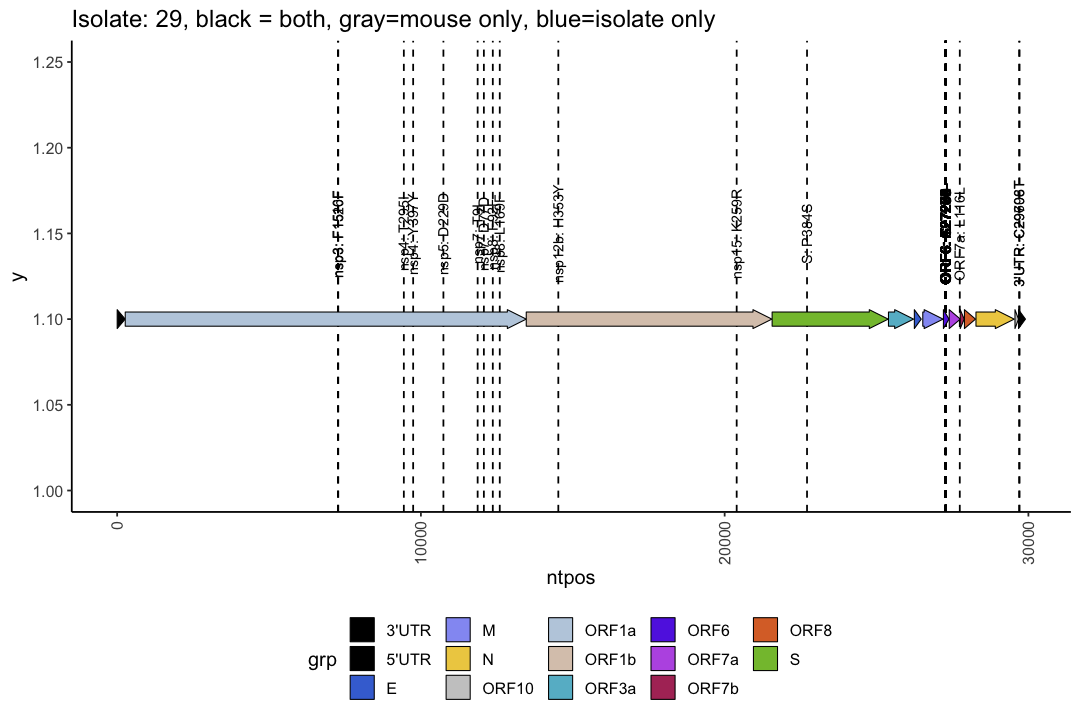

In [81]:
options(repr.plot.width = 9, repr.plot.height = 6)

PlotIsolates(29, DF_TEMP_ALL)

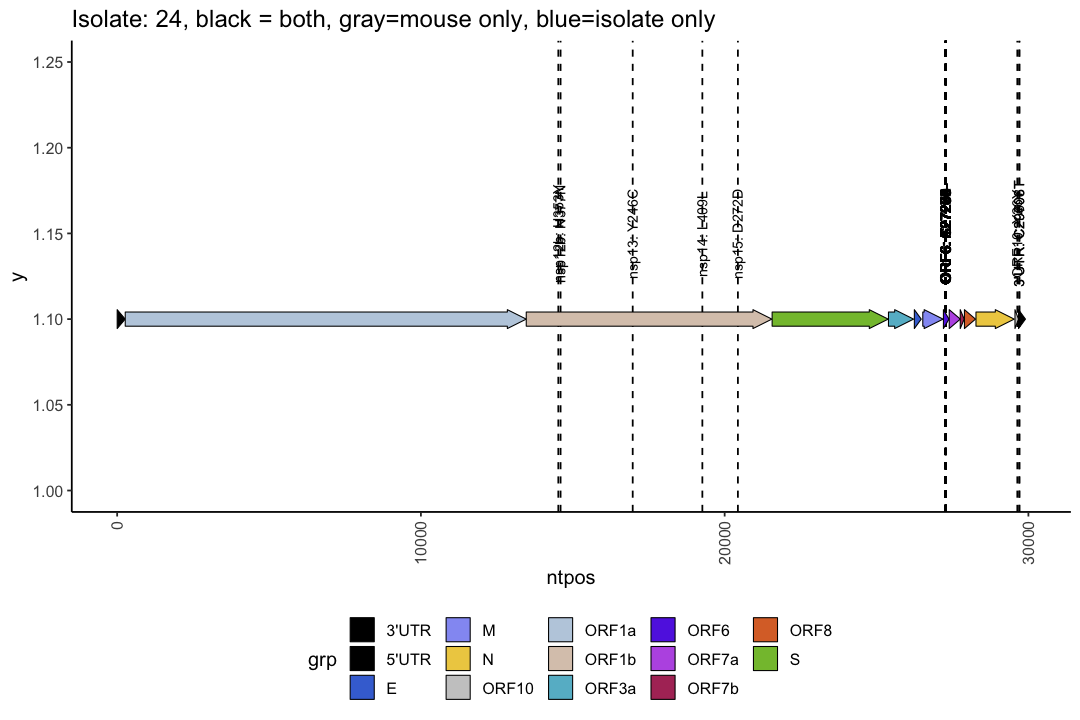

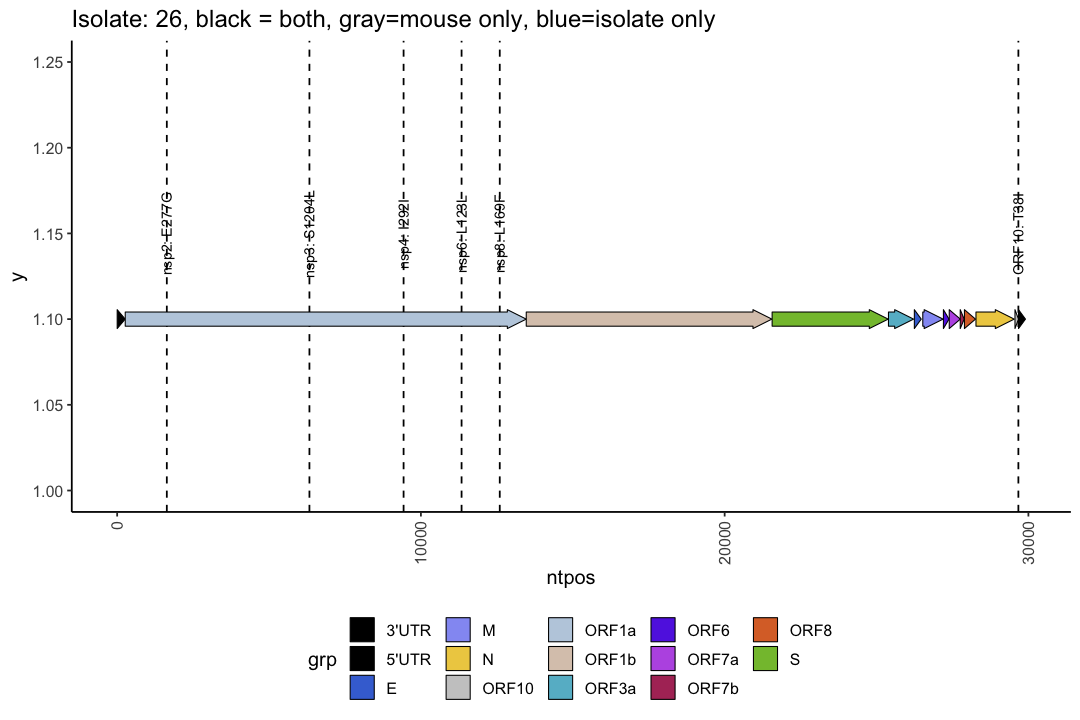

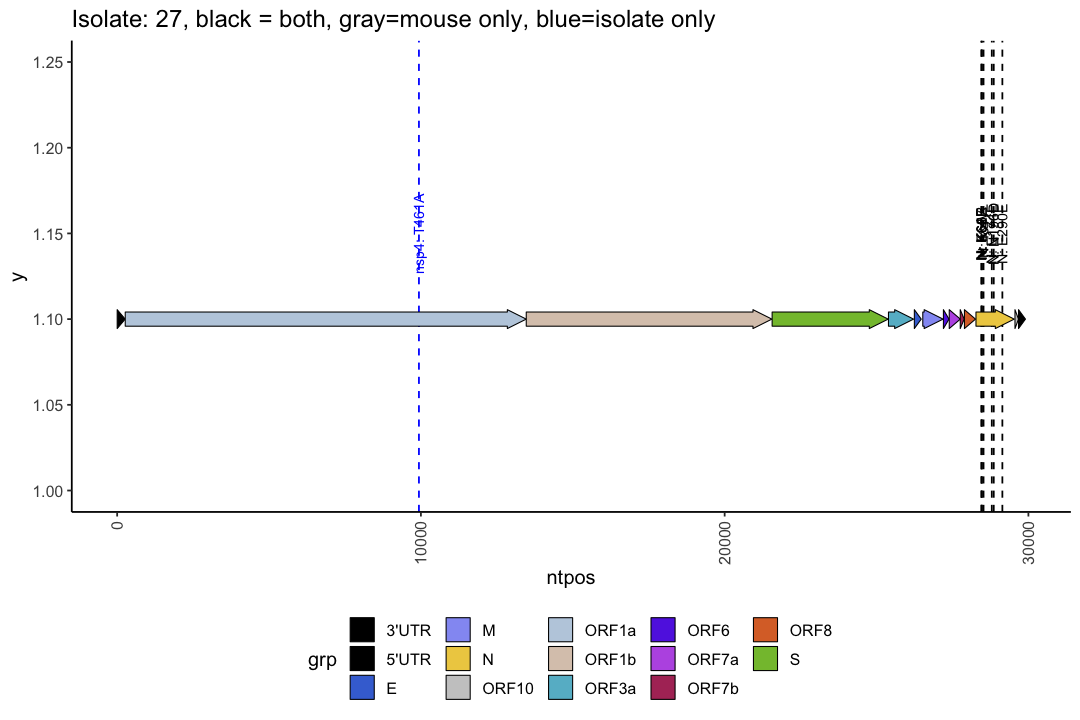

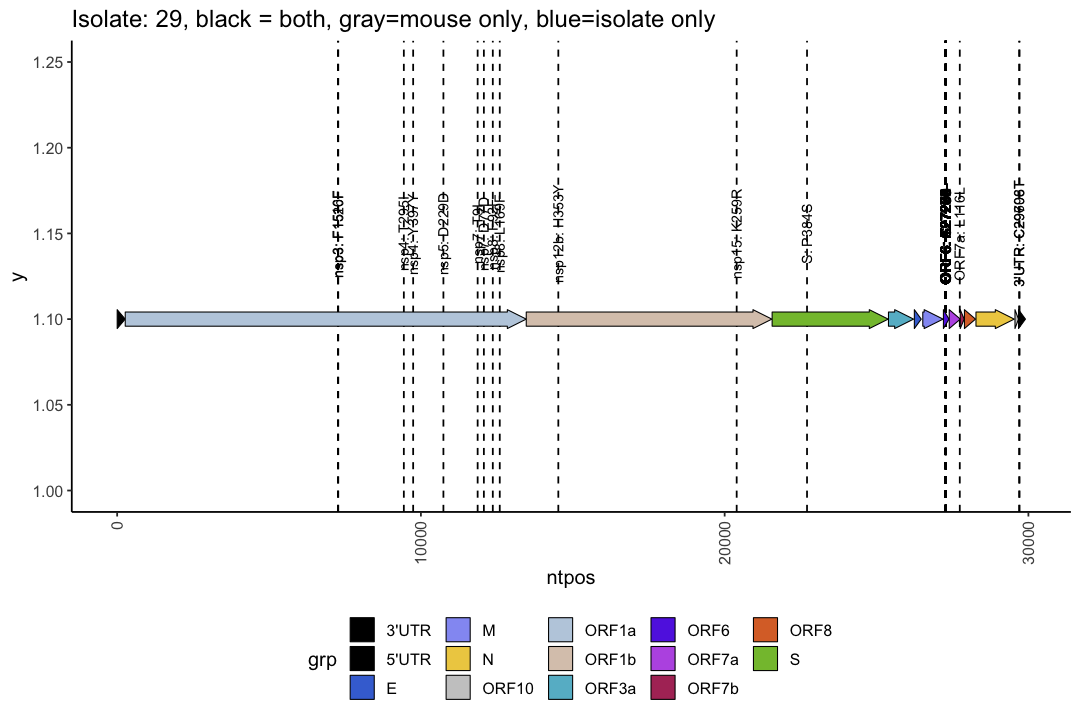

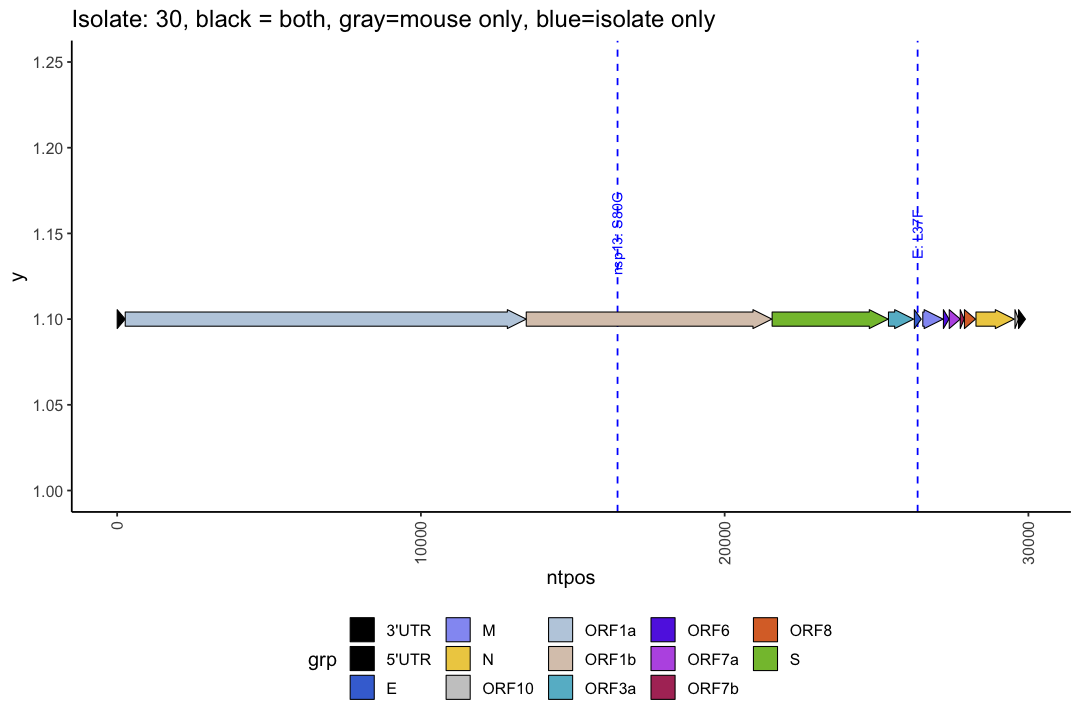

In [82]:
for (i in isolate_mice){
    p = PlotIsolates(i, DF_TEMP_ALL)
    print(p)
    
    
    ggsave(p,
       filename = glue("{FIG_DIR}/isolate{i}.map.png"),
       width = 10,
       height = 4, limitsize=FALSE)

    ggsave(p,
       filename = glue("{FIG_DIR}/isolate{i}.map.pdf"),
       width = 10,
       height = 4, limitsize=FALSE, useDingbats = FALSE)
}


# Deletions

In [83]:
source(glue("{wkdir}/scripts/mehul_extra.R"))
files1 = Sys.glob(glue("{wkdir}/reseq/r1/aasnplist/sample/*"), dirmark = FALSE)
files2 = Sys.glob(glue("{wkdir}/reseq/r2/aasnplist/sample/*"), dirmark = FALSE)

In [84]:
del_list = c(del_list1, del_list2)
del_dfs1 = PullDels(files1, del_list, del_minor1, meta, 'r1')
del_positions1 = del_dfs1$del_positions
MIN_del_positions1 = del_dfs1$MIN_del_positions


del_dfs2 = PullDels(files2, del_list, del_minor2, meta, 'r2')
del_positions2 = del_dfs2$del_positions
MIN_del_positions2 = del_dfs2$MIN_del_positions

In [85]:
MIN_del_positions = merge(MIN_del_positions1 %>% select(-r2), 
                          MIN_del_positions2 %>% select(-r1), 
                             by = c('segment','ntpos','refnt','gene_id','sample_name','type',
                                    'type2','sample_id2','mouse_id2','mouse_id'),
                             all = TRUE) %>%
    mutate(filter_flag = ifelse(
                                major.x == major.y & 
                                totalcount.x >= major_cov &
                                totalcount.y >= major_cov &
                                major.x %in% ntlist |
                                
                                minor.x == minor.y &
                                minor.x %in% ntlist & # this will be the same as minor.y bc of check above
                               totalcount.x >= minor_cov &
                               totalcount.y >= minor_cov &
                               minorfreq.x >= sample_minor_freq &
                               minorfreq.y >= sample_minor_freq, 
                               'pass','fail')) %>%
    rowwise() %>%
    mutate(major = ifelse(filter_flag == 'pass', major.x, NA),
           minor = ifelse(filter_flag == 'pass', minor.x, NA)) %>%
    ungroup()

In [86]:
del_positions = merge(del_positions1 %>% select(-r2), 
                         del_positions2 %>% select(-r1), 
                         by = c('segment','ntpos','refnt','gene_id','sample_name','type',
                                'type2','sample_id2','mouse_id2', 'mouse_id','sample_id'),
                         all = TRUE) %>%
    mutate(filter_flag = ifelse(
                               major.x == major.y & 
                                major.x %in% ntlist, 
                               'pass','fail'),
          totalcount = (totalcount.x + totalcount.y)/2) %>%
    rowwise() %>%
    mutate(major = ifelse(filter_flag == 'pass', major.x, NA)) %>%
    ungroup()

In [87]:
dels = merge(del_positions %>% 
                filter(gene_id %in% gene_ord_list) %>% 
                select(sample_name, totalcount, ntpos, major, gene_id, type, mouse_id, sample_id,type2, mouse_id2, sample_id2) %>%
                unique(),
    stock_con,
    by=c('ntpos', 'gene_id'))

Genes/ORFs with deletions: c("nsp6", "ORF1a", "ORF6", "S")



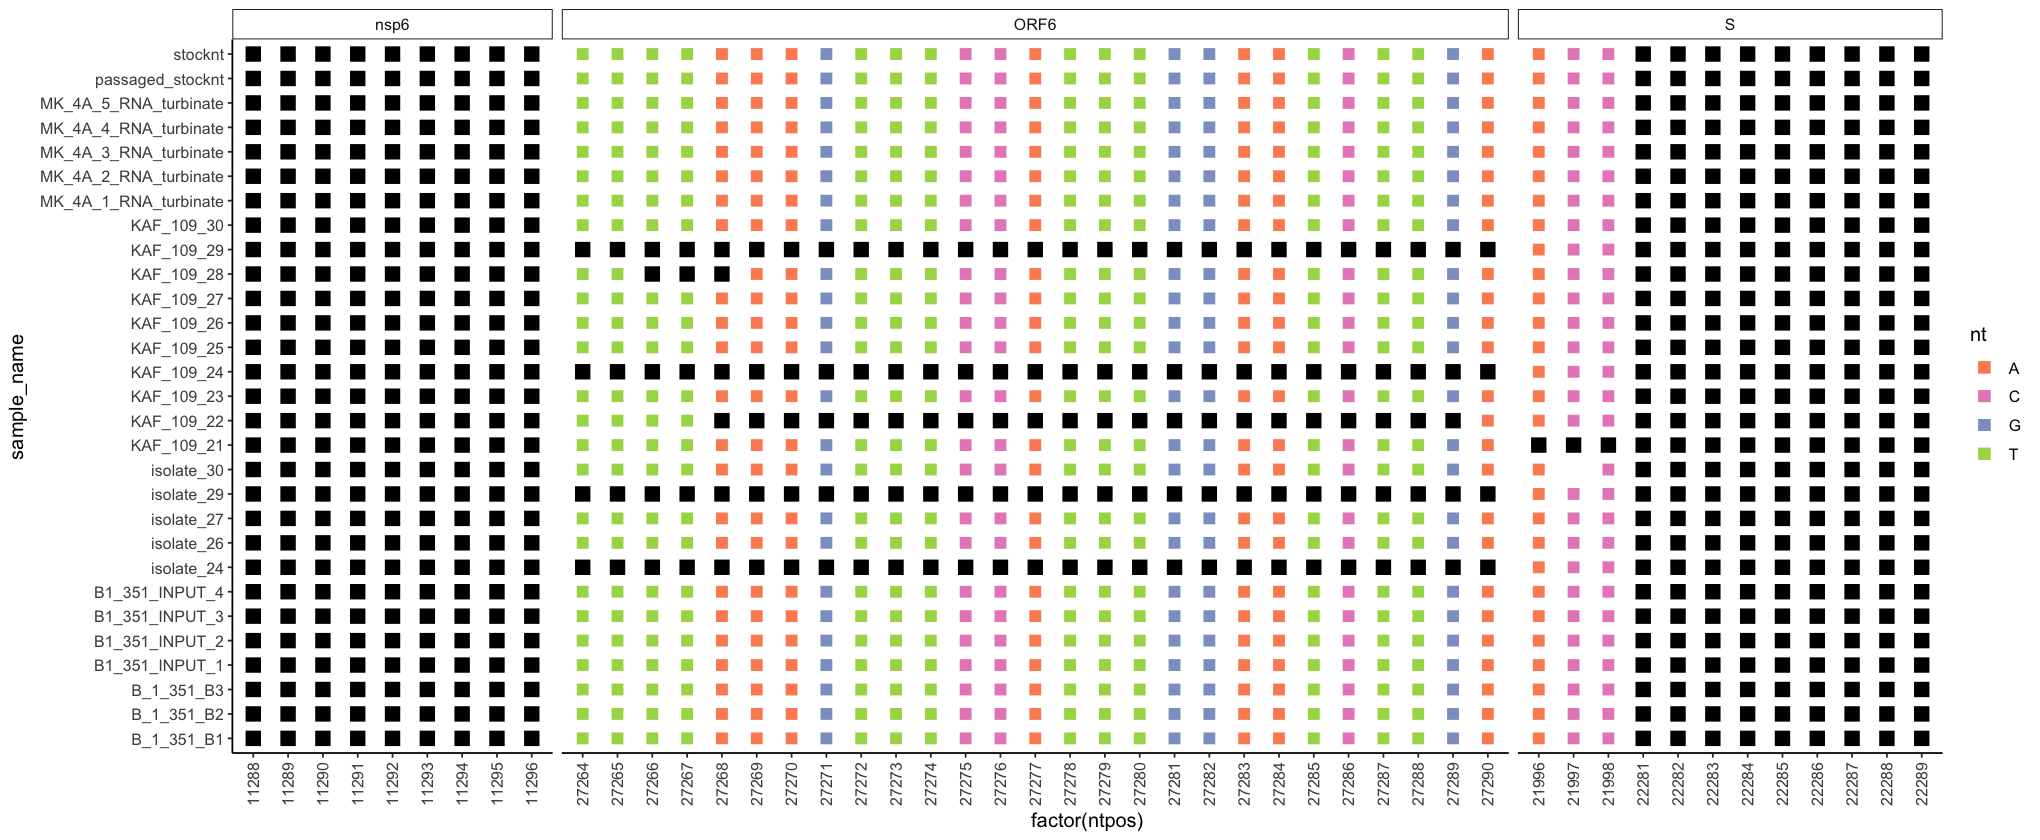

In [88]:
message("Genes/ORFs with deletions: ", list(levels(factor(dels$gene_id))))

plot_del(dels, orf_group, ntlist, major_cov)

In [89]:
stock_con %>% 
    filter(gene_id == 'ORF6' & stocknt == '-')

gene_id,ntpos,aapos,passaged_stocknt,passaged_stockaa,passaged_dp,stocknt,stockaa,prepass_dp
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [90]:
# samples with deletions
samps_w_dels = c('MK_4A_1_RNA_turbinate','MK_4A_2_RNA_turbinate','MK_4A_3_RNA_turbinate',
                 'MK_4A_4_RNA_turbinate','MK_4A_5_RNA_turbinate',
                 "KAF_109_29","KAF_109_28","KAF_109_24","KAF_109_22")

spike_dels = c("KAF_109_21")

In [91]:
MIN_del_positions$type2 = factor(MIN_del_positions$type2, levels = c('input','input_vero','input-C57/BL6','sample','isolate'))

Warning message:
“Removed 27 rows containing non-finite values (`stat_boxplot()`).”


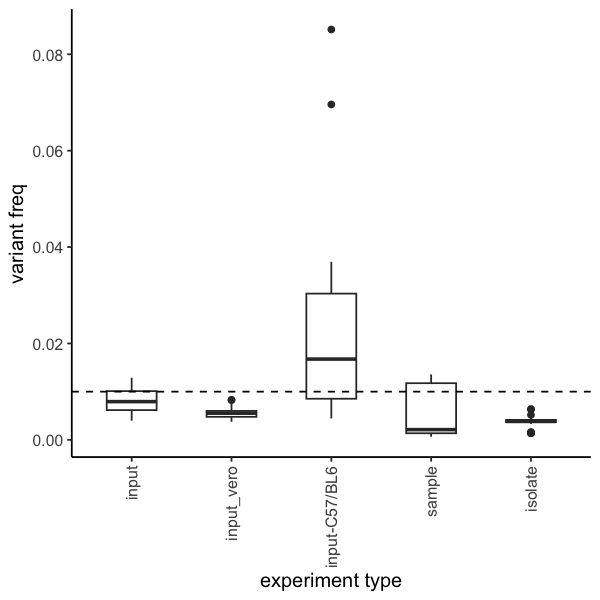

In [92]:
options(repr.plot.width = 5, repr.plot.height = 5)

p26 = MIN_del_positions %>% filter( filter_flag == 'pass' & 
                             minor == '-' & 
                             gene_id == 'ORF6' &
                             ntpos %in% (dels %>% filter(major == '-' & gene_id == 'ORF6'))$ntpos) %>%
    ggplot(., aes(x=type2, y=(minorfreq.x+minorfreq.y)/2)) +
    geom_boxplot(width = 0.5) + 
    geom_hline(linetype = 2, yintercept = 0.01) + 
    labs(x= 'experiment type',y='variant freq') + 
    PlotTheme1

p26

In [93]:
ggsave(p26,
       filename = glue("{FIG_DIR}/minor.deletions.png"),
       width = 3,
       height = 4, limitsize=FALSE)

ggsave(p26,
       filename = glue("{FIG_DIR}/minor.deletions.pdf"),
       width = 3,
       height = 4, limitsize=FALSE, useDingbats = FALSE)

Warning message:
“Removed 27 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 27 rows containing non-finite values (`stat_boxplot()`).”


In [94]:
dels$type = factor(dels$type, levels = sample_levels)

In [95]:
dels$sample_id2 = factor(dels$sample_id2, levels = sample_labels)

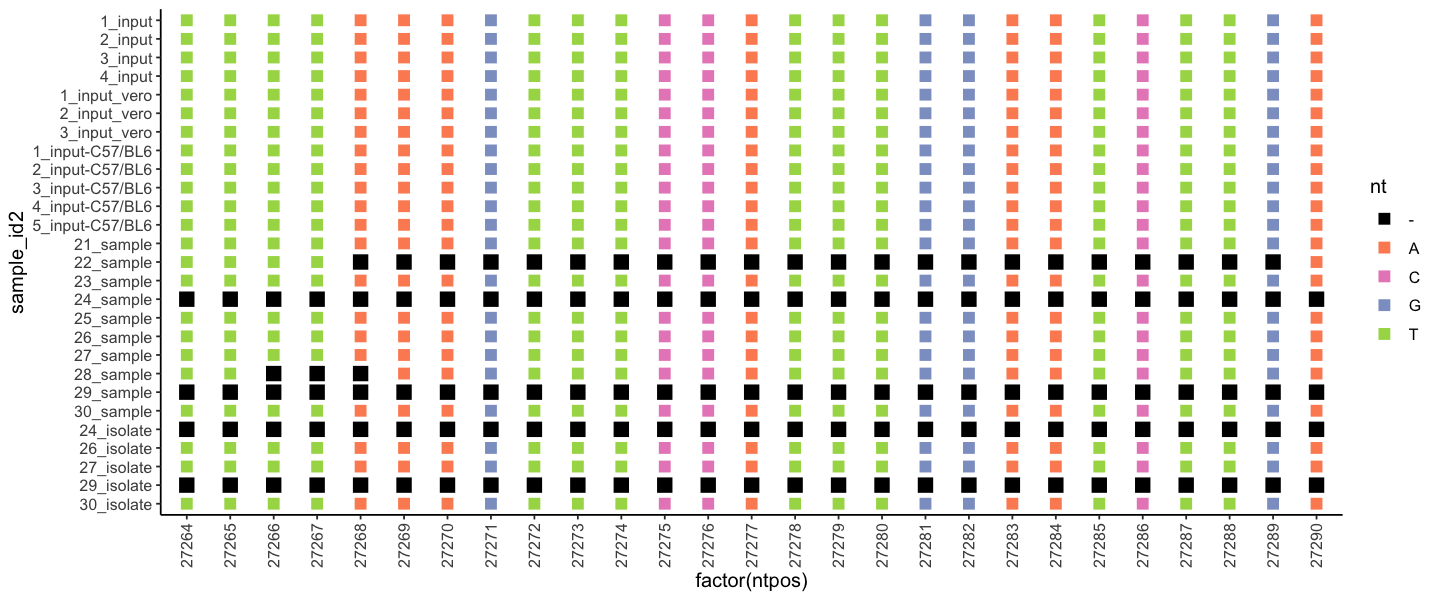

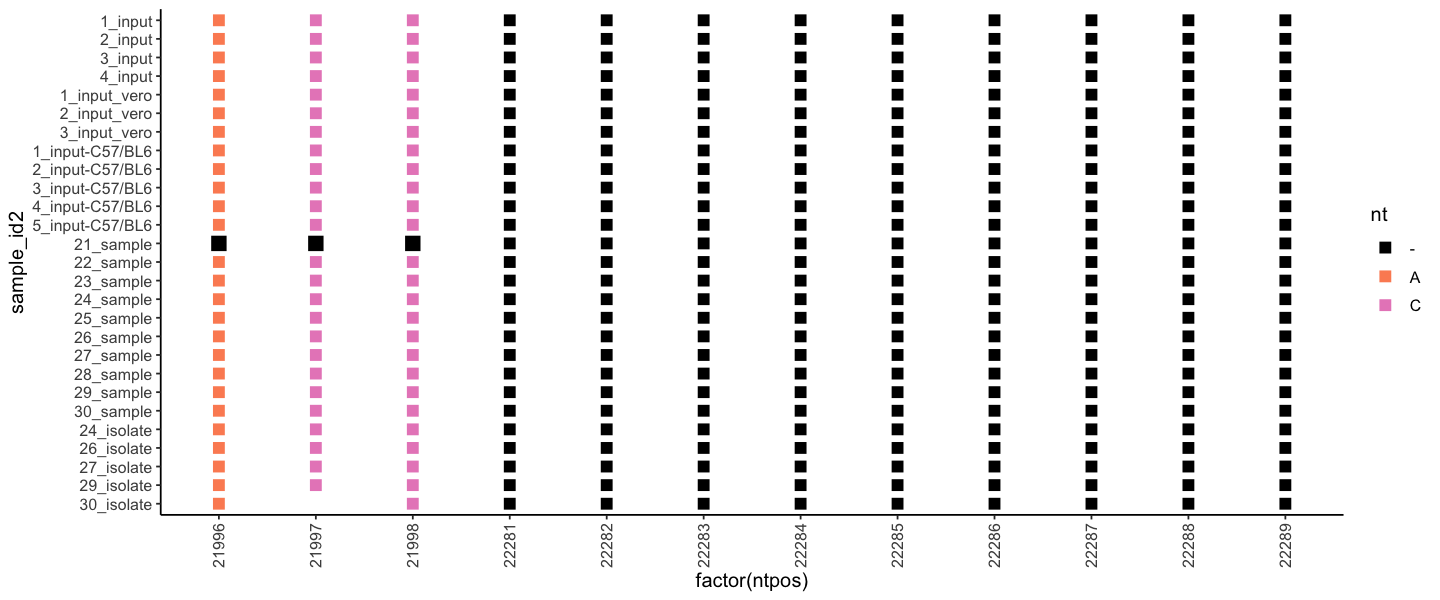

In [96]:
options(repr.plot.width = 12, repr.plot.height = 5)
# consenseus positions with deletions
p = plot_gene_del(dels,'ORF6', meta$sample_name, orf_group, ntlist, major_cov)

p

ggsave(p,
       filename = glue("{FIG_DIR}/orf6.del.png"),
       width = 7,
       height = 6, limitsize=FALSE)

ggsave(p,
       filename = glue("{FIG_DIR}/orf6.del.pdf"),
       width = 7,
       height = 6, limitsize=FALSE, useDingbats = FALSE)

p2 = plot_gene_del(dels,'S', meta$sample_name, orf_group, ntlist, major_cov)

p2

ggsave(p2,
       filename = glue("{FIG_DIR}/spike.del.png"),
       width = 5,
       height = 5, limitsize=FALSE)

ggsave(p2,
       filename = glue("{FIG_DIR}/spike.del.pdf"),
       width = 5,
       height = 6, limitsize=FALSE, useDingbats = FALSE)
#plot_gene_del(dels,'S', spike_dels, orf_group, ntlist, major_cov)

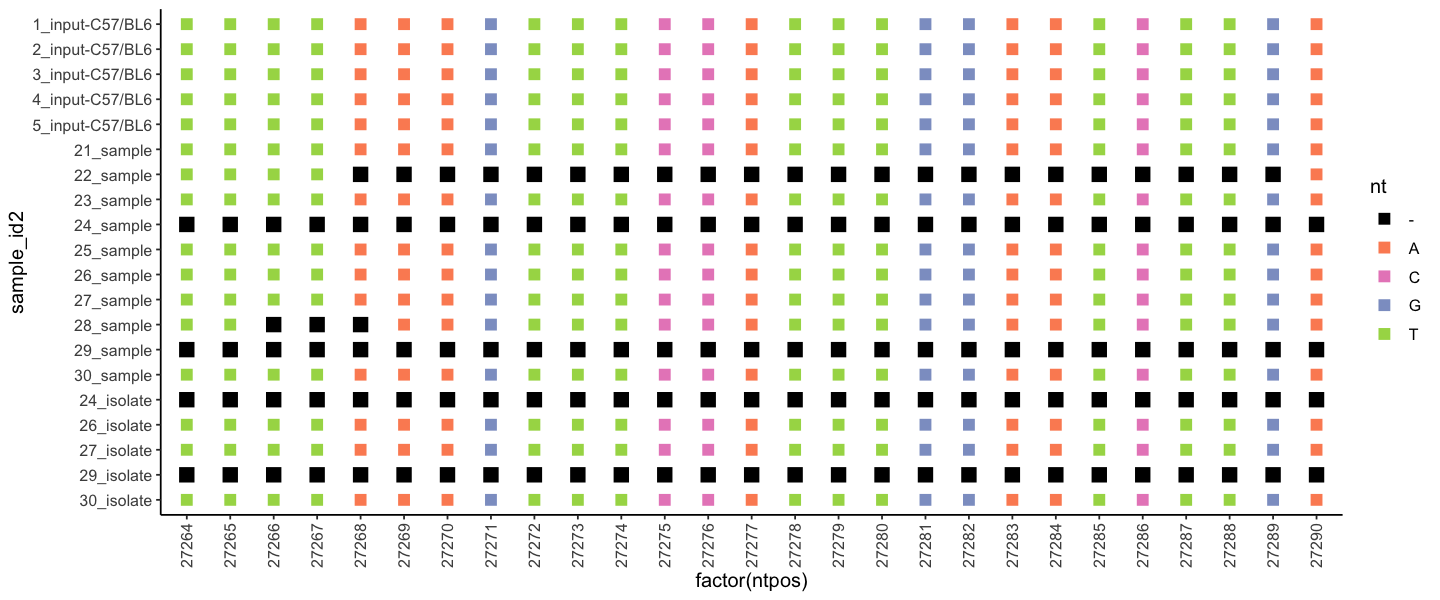

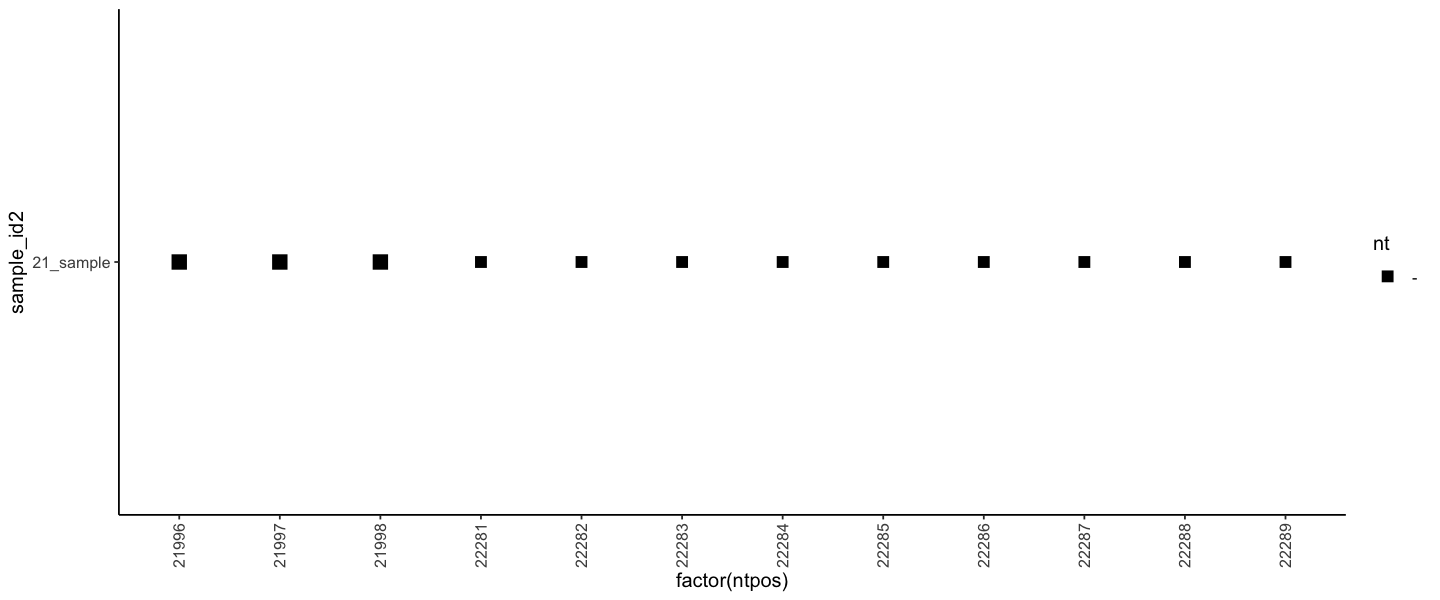

In [97]:
options(repr.plot.width = 12, repr.plot.height = 5)

plot_gene_del(dels,'ORF6', c((meta %>% filter(!type %in% c('stock','passaged_stock')))$sample_name), orf_group, ntlist, major_cov)

plot_gene_del(dels,'S', spike_dels, orf_group, ntlist, major_cov)

In [98]:
# BELOW 1%
DF_DEL %>% filter(type %in% c('passaged_stock','stock') &
                 ntpos %in% levels(factor(dels$ntpos)) &
                 gene_id == 'ORF6' & vartype == 'minor')

sample_name,gene_id,ntpos,aapos,type,varnt,varaa,varcodon,refnt,refaa,⋯,varfreq,totalcount,n,vartype,majornt,majoraa,var_info,var_info_nt,VAR,filter_flag
<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<glue>,<chr>
B1_351_INPUT_1,ORF6,27267,22,stock,-,,,T,F,⋯,0.01267089,2588.5,2,minor,T,F,F22,T27267-,27267-,FAIL
B1_351_INPUT_1,ORF6,27268,23,stock,-,,,A,K,⋯,0.01288744,2576.5,2,minor,A,K,K23,A27268-,27268-,FAIL
B1_351_INPUT_3,ORF6,27267,22,stock,-,,,T,F,⋯,0.01172609,2535.0,2,minor,T,F,F22,T27267-,27267-,FAIL
B1_351_INPUT_3,ORF6,27268,23,stock,-,,,A,K,⋯,0.01197015,2532.5,2,minor,A,K,K23,A27268-,27268-,FAIL


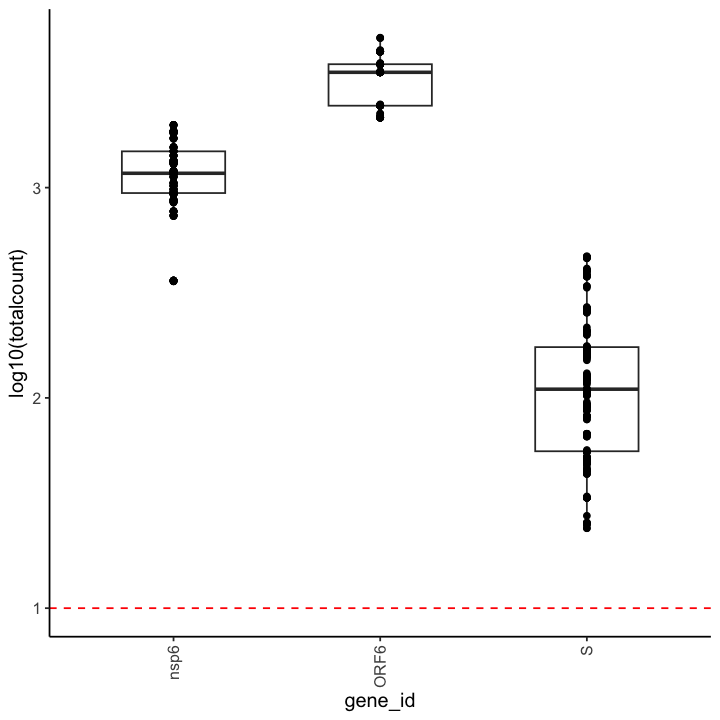

In [99]:
# coverage at these deletion positions: 
options(repr.plot.width = 6, repr.plot.height = 6)

ggplot(dels %>% filter(major == '-' & totalcount >= major_cov & !gene_id %in% orf_group) %>%
           unique(),
       aes(x=gene_id, y = log10(totalcount))) +
    geom_boxplot(width = 0.5) + 
    geom_hline(yintercept = log10(major_cov), linetype = 2, color = 'red') +
    geom_point() + 
    PlotTheme1

In [100]:
dels %>% filter(gene_id == 'ORF6' & sample_name %in% samps_w_dels & totalcount < major_cov) %>% select(sample_name, ntpos, totalcount) %>% unique()

dels %>% filter(gene_id == 'S' & sample_name %in% spike_dels & totalcount < major_cov) %>% select(sample_name, ntpos, totalcount) %>% unique()

sample_name,ntpos,totalcount
<chr>,<int>,<dbl>


sample_name,ntpos,totalcount
<chr>,<int>,<dbl>


In [101]:
files = Sys.glob(glue("{wkdir}/reseq/r1/aasnplist/dels/*"), dirmark = FALSE)

message("ORF6 dels: ")
for (s in files){
    df = read.csv(s, header = TRUE)
    print(head(s))
    df$name = gsub("-","_", df$name)
    temp = df %>% filter(gene_id == 'ORF6') %>%
                filter(name %in% samps_w_dels | name %in% stocks) %>%
                arrange(ntpos) %>% unique()
    seq = c(temp$major)
    print(paste(seq, collapse=''))

}



ORF6 dels: 



[1] "/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mehul_mice/reseq/r1/aasnplist/dels/B_1_351_B1.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] ""
[1] "/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mehul_mice/reseq/r1/aasnplist/dels/B_1_351_B2.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] ""
[1] "/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mehul_mice/reseq/r1/aasnplist/dels/KAF_109_21.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] ""
[1] "/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mehul_mice/reseq/r1/aasnplist/dels/KAF_109_22.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] "ATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGGGGACTTTT----------------------ATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAA"
[1] "/Users/johnsonkate/OneDrive - National Institutes of 

In [102]:
message("Spike dels: ")
for (s in files){
    df = read.csv(s, header = TRUE)
    print(head(s))

    df$name = gsub("-","_", df$name)

    temp = df %>% filter(gene_id == 'S') %>%
                filter(name %in% spike_dels | name %in% stocks) %>%
                arrange(ntpos) %>% unique()
    seq = c(temp$major)
    print(paste(seq, collapse=''))

}

Spike dels: 



[1] "/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mehul_mice/reseq/r1/aasnplist/dels/B_1_351_B1.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] ""
[1] "/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mehul_mice/reseq/r1/aasnplist/dels/B_1_351_B2.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] ""
[1] "/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/mehul_mice/reseq/r1/aasnplist/dels/KAF_109_21.COV19.NC_045512.2.0.001.aa.snplist.csv"
[1] "ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGCTAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATT--

## Translated ORF6 sequences : 

>B-1-351-B1: MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTENKYSQLDEEQPMEID*

>B-1-351-B2: MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTENKYSQLDEEQPMEID*

>KAF-109-22: MFHLVDFQVTIAEILLIIMGTFITS*TS*LKIYLSH*LRINILN*MKSNQWRLI

>KAF-109-28: MFHLVDFQVTIAEILLIIMRT*VSIWNLDYIINLIIKNLSKSLTENKYSQLDEEQPMEID*

>KAF-109-24: MFHLVDFQVTIAEILLIIMRTYIINLIIKNLSKSLTENKYSQLDEEQPMEID*

>KAF-109-29: MFHLVDFQVTIAEILLIIMRTYIINLIIKNLSKSLTENKYSQLDEEQPMEID*


In [103]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/johnsonkate/anaconda3/envs/renv3/lib/libopenblasp-r0.3.20.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] gggenes_0.5.0   pals_1.7        seqinr_4.2-30   glue_1.6.2     
 [5] lubridate_1.9.2 forcats_1.0.0   stringr_1.5.0   dplyr_1.1.2    
 [9] purrr_1.0.2     tidyr_1.3.0     tibble_3.2.1    tidyverse_2.0.0
[13] plyr_1.8.8      reshape2_1.4.4  readr_2.1.4     ggplot2_3.4.3  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-9      tidyselect_1.2.0  repr_1.1.6        colorspace_2.1-0 
 [5] vctrs_0.6.3       generics_0.1.3    htmltools_0.5.6   base64enc_0.1-3  
 [9] utf8_1.2.3        rlang_1.1.1       pillar_1.9.0      withr_2.5.0      
[13] uuid_1.1-1        lif